- [Overview](#overview)
    - [Etiquette](#etiquette)
    
- [Feature Engineering](#feature_engineering)
    - [(1) Data Import](#data_import)
    - [(2) Matplotlib Color & Default Setting](#data_combine)
    - [(3) Data Visualization](#handling_missing_values)
    - [(4) Feature Encoding](#feature_encoding)
    - [(5) Split Data](#split_data)
    - [(6) Limitation](#limitation)
    
- [Scikit Learn](#scikit_learn)
    - [(1) Data Split](#data_split)
    - [(2) Base Model - Decision Tree](#base_model_tree)
    - [(3) Create Helper Class and Submission Function](#helper_class)
        * [(A) DecisionTreeClassifier](#DecisionTreeClassifier)
        * [(B) RandomForestClassifier](#RandomForestClassifier)
        * [(C) LightGBM](#lightgbm)
        * [(D) Feature Importance](#feature_importance)
        * [(E) Submission](#submission) 

<a id="overview"></a>
## Overview
- This is my personal tutorial sharing with my students as example. 
- The whole processes will be shared from EDA to Modeling and Evaluation, Finally Submission. 
    + Let's Check My [EDA Code](https://www.kaggle.com/j2hoon85/2021-april-play-ground-eda-for-kaggle-newbies)
- The well-known notebooks shared will be enough for students to learn Kaggle as an entry level. 

> Happy to Code

<a id='etiquette'></a>
### Etiquette
- When students get codes and ideas from other notebooks, then please make sure to leave a reference and upvote it as well. 👆👆👆

<a id="feature_engineering"></a>
## Feature Engineering
- After EDA, it's time to conduct Feature Engineering. 
- If you are not familiar with this concept, then please read a book

![Feature Engineering for Machine Learning](https://learning.oreilly.com/library/cover/9781491953235/250w/)
    
- And If you need a short summary about feature engineering, then please check this article as well. 
    + [@Chris Deotte Feature Engineering Techniques](https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575)

<a id='data_import'></a>
### (1) Data Import
- Let's get datasets

In [1]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import lightgbm
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import random

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

RANDOM_SEED = 2021
PROBAS = True
FOLDS = 5
N_ESTIMATORS = 1000

TARGET = 'Survived'
    


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)

In [2]:
train = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test= pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')

train.shape, test.shape, sample_submission.shape

((100000, 12), (100000, 11), (100000, 2))

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [5]:
sample_submission.head()

,PassengerId,Survived
0,100000,1
1,100001,1
2,100002,1
3,100003,1
4,100004,1


In [6]:
train.dtypes[train.dtypes != 'object'].index.tolist()

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

### (2)Matplotlib Color & Default Setting

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
print(mpl.__version__)

3.4.1


In [8]:
from cycler import cycler

mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['font.family'] = 'serif'

raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

light_palette = np.array(raw_light_palette)/255


mpl.rcParams['axes.prop_cycle'] = cycler('color',light_palette)

survived_palette = ['#dddddd', mpl.colors.to_hex(light_palette[2])]

sex_palette = [light_palette[0], light_palette[3]]

### (3)Data visualization

성별에 따른 생존 비율을 나타낸 그래프

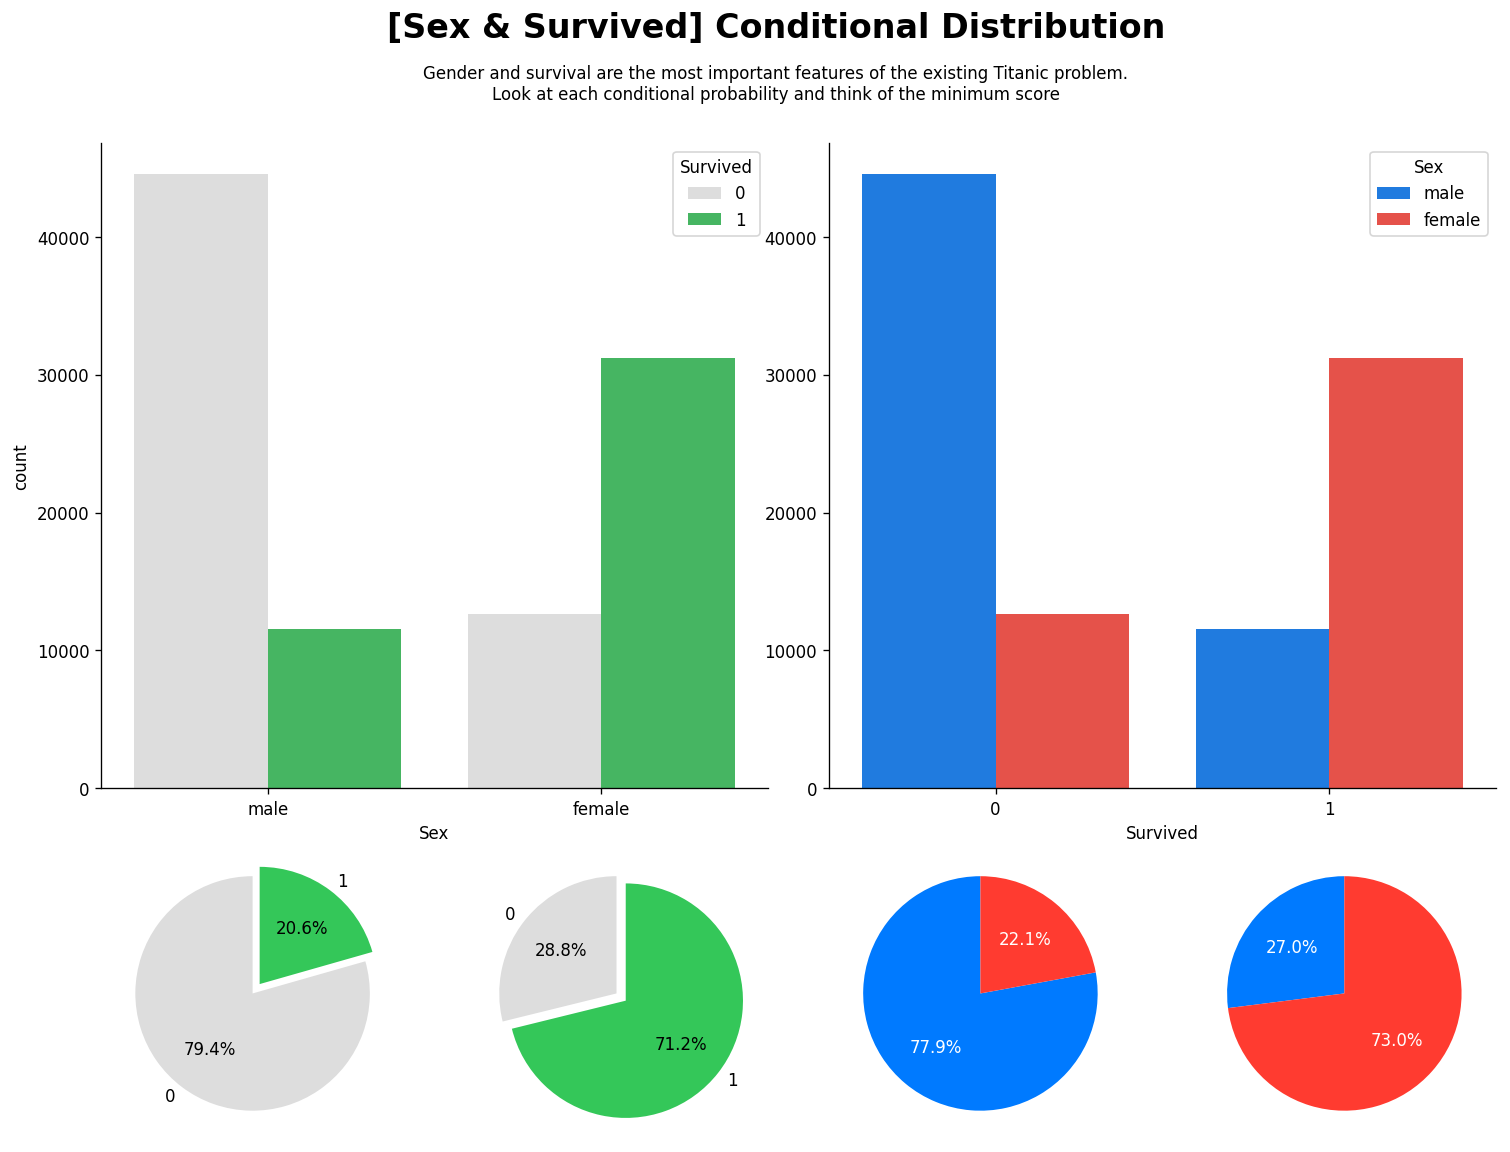

In [9]:
fig = plt.figure(figsize=(15, 11))

gs = fig.add_gridspec(3, 4) # row size * column size 형태의 1차원 어레이, subplot 사이즈 조절. 한 화면을 3 x 4 형태로 분할한다고 생각하면 됨.




ax_sex_survived = fig.add_subplot(gs[:2,:2])
sns.countplot(x='Sex',hue='Survived', data=train, ax=ax_sex_survived, 
              palette=survived_palette)

ax_survived_sex = fig.add_subplot(gs[:2,2:4], sharey=ax_sex_survived)
sns.countplot(x='Survived',hue='Sex', data=train, ax=ax_survived_sex,
              palette=sex_palette
             )

# ax_survived_sex.set_yticks([])
ax_survived_sex.set_ylabel('')

ax_pie_male = fig.add_subplot(gs[2, 0])
ax_pie_female = fig.add_subplot(gs[2, 1])
ax_pie_notsurvived = fig.add_subplot(gs[2, 2])
ax_pie_survived = fig.add_subplot(gs[2, 3])

# Sex
male = train[train['Sex']=='male']['Survived'].value_counts().sort_index()
ax_pie_male.pie(male, labels=male.index, autopct='%1.1f%%',explode = (0, 0.1), startangle=90,
               colors=survived_palette
               )


female = train[train['Sex']=='female']['Survived'].value_counts().sort_index()
ax_pie_female.pie(female, labels=female.index, autopct='%1.1f%%',explode = (0, 0.1), startangle=90,
                colors=survived_palette
                 )

# Survived
notsurvived = train[train['Survived']==0]['Sex'].value_counts()[['male', 'female']]
ax_pie_notsurvived.pie(notsurvived, labels=notsurvived.index, autopct='%1.1f%%',startangle=90,
                      colors=sex_palette, textprops={'color':"w"}
                      )

survived = train[train['Survived']==1]['Sex'].value_counts()[['male', 'female']]
ax_pie_survived.pie(survived, labels=survived.index, autopct='%1.1f%%', startangle=90,
                    colors=sex_palette, textprops={'color':"w"}
                   )

fig.suptitle('[Sex & Survived] Conditional Distribution', fontweight='bold', fontsize=20)
fig.text(s='''Gender and survival are the most important features of the existing Titanic problem.\nLook at each conditional probability and think of the minimum score''', 
         x=0.5, y= 0.94, ha='center', va='top')

plt.show()

연령대별 생존 확률을 나타낸 그래프

In [10]:
def age_band(num):
    for i in range(1, 100):
        if num < 10*i : return f'{(i-1) * 10} ~ {i*10}'
        
        
train['Age band'] = train['Age'].apply(age_band)
titanic_age = train[['Age band', 'Survived']].groupby('Age band')['Survived'].value_counts().sort_index().unstack()
titanic_age['Survival rate'] = titanic_age[1] / (titanic_age[0] + titanic_age[1]) * 100
age_band = train['Age band'].value_counts().sort_index()
print(age_band)

0 ~ 10      8611
10 ~ 20     4999
20 ~ 30    20283
30 ~ 40    15783
40 ~ 50    15677
50 ~ 60    18134
60 ~ 70    10819
70 ~ 80     2318
80 ~ 90       84
Name: Age band, dtype: int64


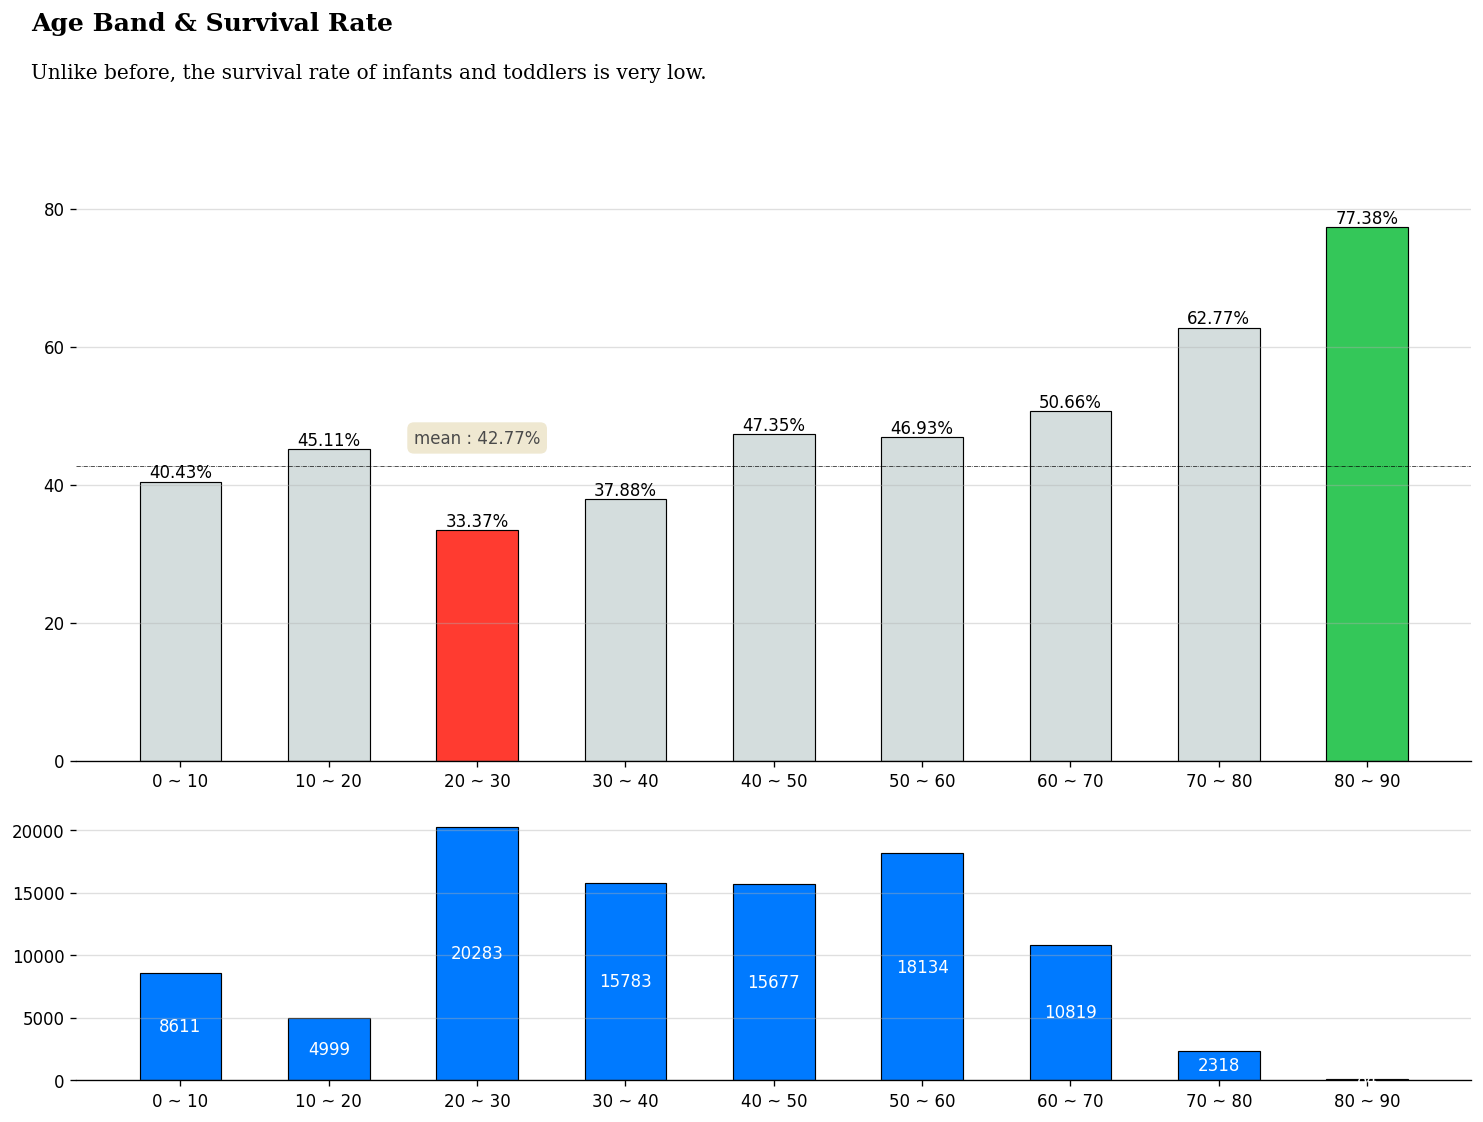

In [11]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:-1,:])

color_map = ['#d4dddd' for _ in range(9)]
color_map[2] = light_palette[3]
color_map[8] = light_palette[2]


bars = ax.bar(titanic_age['Survival rate'].index, titanic_age['Survival rate'], 
       color=color_map, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.bar_label(bars, fmt='%.2f%%')


# mean line + annotation
mean = train['Survived'].mean() *100
ax.axhline(mean ,color='black', linewidth=0.4, linestyle='dashdot')
ax.annotate(f"mean : {mean :.4}%", 
            xy=('20 ~ 30', mean + 4),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))
    


ax.set_yticks(np.arange(0, 81, 20))
ax.grid(axis='y', linestyle='-', alpha=0.4)
ax.set_ylim(0, 85)


ax_bottom = fig.add_subplot(gs[-1,:])
bars = ax_bottom.bar(age_band.index, age_band, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax_bottom.spines[["top","right","left"]].set_visible(False)
ax_bottom.bar_label(bars, fmt='%d', label_type='center', color='white')
ax_bottom.grid(axis='y', linestyle='-', alpha=0.4)

# Title & Subtitle    
fig.text(0.1, 1, 'Age Band & Survival Rate', fontsize=15, fontweight='bold', fontfamily='serif', ha='left')
fig.text(0.1, 0.96, 'Unlike before, the survival rate of infants and toddlers is very low.', fontsize=12, fontweight='light', fontfamily='serif', ha='left')

plt.show()

변수 간 상관관계를 나타낸 그래프

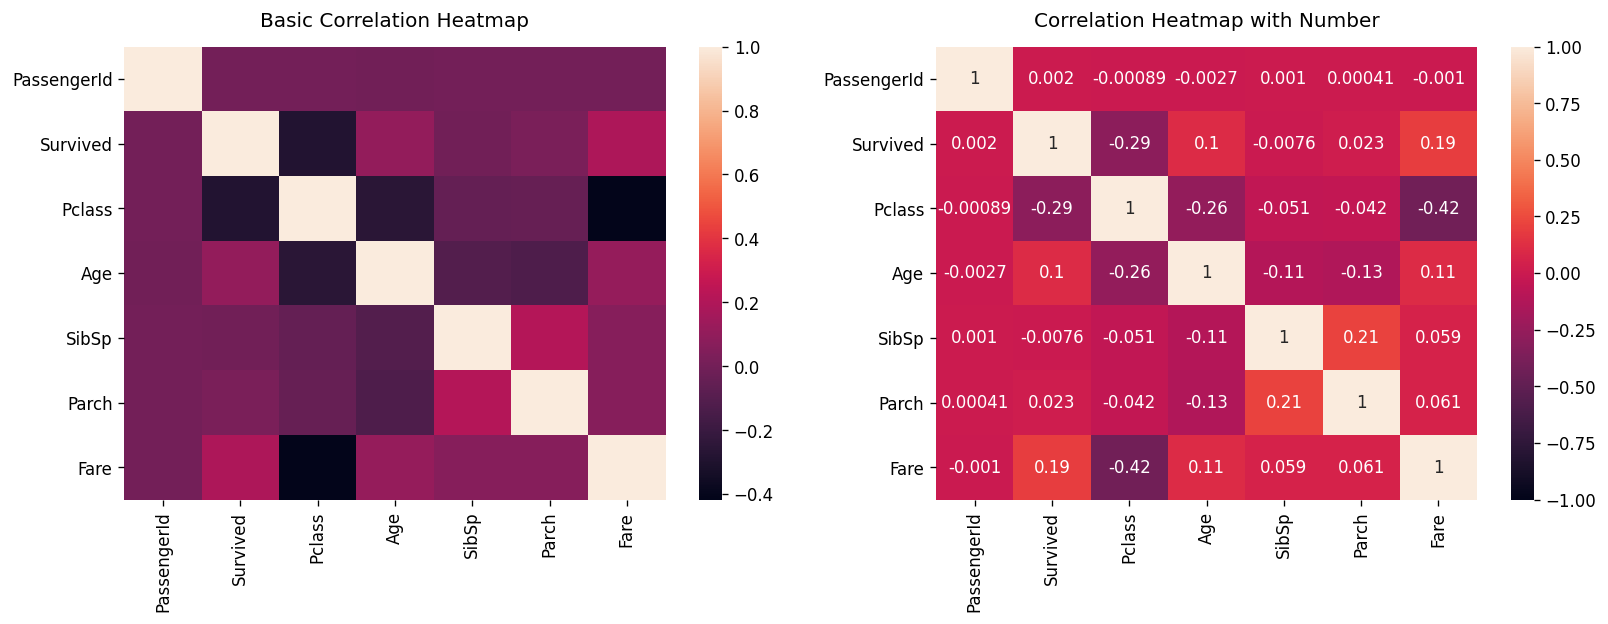

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16,5))

# 기본 그래프
sns.heatmap(train.corr(), ax=ax[0])
ax[0].set_title('Basic Correlation Heatmap', pad = 12)

# 상관관계 수치 그래프
sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True, ax=ax[1])
ax[1].set_title('Correlation Heatmap with Number', pad = 12)

plt.show()

나이가 많고 요금을 많이 낸 승객의 생존확률이 높을 것이라는 가정하에서 승객들이 낸 요금과 나이를 곱하여 변수를 만들었고 특정 구간별로 범주를 나누어 생존확률을 분석한 그래프

In [13]:
def get_category_fare_age(fare_age):
    cat = ''
    if fare_age <= -1: cat = 'Unknown'
    elif fare_age <= 5000: cat = 'Low'
    elif fare_age <= 10000: cat = 'Middle '
    elif fare_age <= 20000: cat = 'High'
    elif fare_age <= 40000: cat = 'Very High'
    else : cat = 'Ultra High'
    
    return cat

In [14]:
train['Age'].fillna(train['Age'].mean(), inplace=True)
train['Fare'].fillna(train['Fare'].mean(), inplace=True)

train['Fare*Age'] = train['Age'] * train['Fare']
train['Fare*Age'] = train['Fare*Age'].apply(lambda x : get_category_fare_age(x))
titanic_fare_age = train[['Fare*Age', 'Survived']].groupby('Fare*Age')['Survived'].value_counts().sort_index().unstack()
titanic_fare_age['Survival rate'] = titanic_fare_age[1] / (titanic_fare_age[0] + titanic_fare_age[1]) * 100

Fare_Age = train['Fare*Age'].value_counts().sort_index()

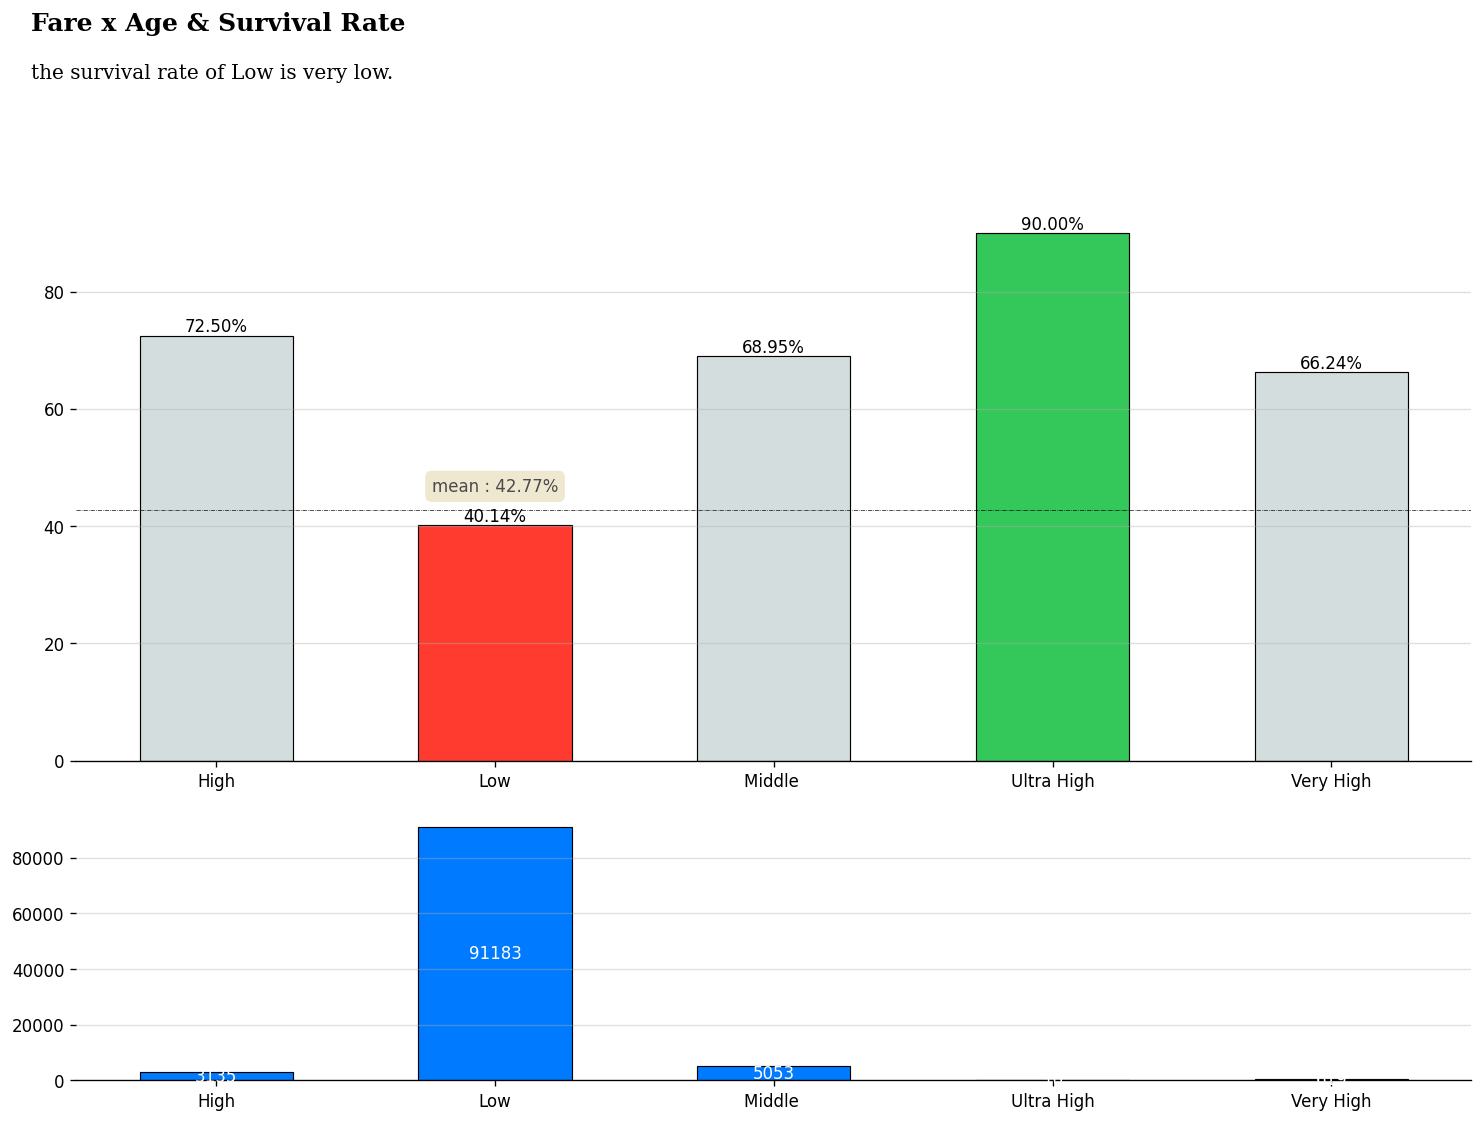

In [15]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:-1,:])

color_map = ['#d4dddd' for _ in range(5)]
color_map[1] = light_palette[3]
color_map[3] = light_palette[2]


bars = ax.bar(titanic_fare_age['Survival rate'].index, titanic_fare_age['Survival rate'], 
       color=color_map, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax.spines[["top","right","left"]].set_visible(False)
ax.bar_label(bars, fmt='%.2f%%')


# mean line + annotation
mean = train['Survived'].mean() *100
ax.axhline(mean ,color='black', linewidth=0.4, linestyle='dashdot')
ax.annotate(f"mean : {mean :.4}%", 
            xy=('Low', mean + 4),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))
    



ax.set_yticks(np.arange(0, 100, 20))
ax.grid(axis='y', linestyle='-', alpha=0.4)
ax.set_ylim(0, 100)


ax_bottom = fig.add_subplot(gs[-1,:])
bars = ax_bottom.bar(Fare_Age.index, Fare_Age, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax_bottom.spines[["top","right","left"]].set_visible(False)
ax_bottom.bar_label(bars, fmt='%d', label_type='center', color='white')
ax_bottom.grid(axis='y', linestyle='-', alpha=0.4)

# Title & Subtitle    
fig.text(0.1, 1, 'Fare x Age & Survival Rate', fontsize=15, fontweight='bold', fontfamily='serif', ha='left')
fig.text(0.1, 0.96, 'the survival rate of Low is very low.', fontsize=12, fontweight='light', fontfamily='serif', ha='left')

plt.show()

각각의 변수 안에 특정 값이 생존률에 어떠한 영향을 미치는지 직관적으로 파악하기 위한 그래프

In [16]:
num_columns = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [17]:
def show_hist_by_target(df, columns):
    cond_1 = (df['Survived'] == 1)
    cond_0 = (df['Survived'] == 0)

    for column in columns:
        fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
        sns.violinplot(x='Survived', y=column, data=df, ax=axs[0][0])
        sns.distplot(df[cond_1][column], label='1', color='red', ax=axs[0][1])
        sns.distplot(df[cond_0][column], label='0', color='blue', ax=axs[0][1])  

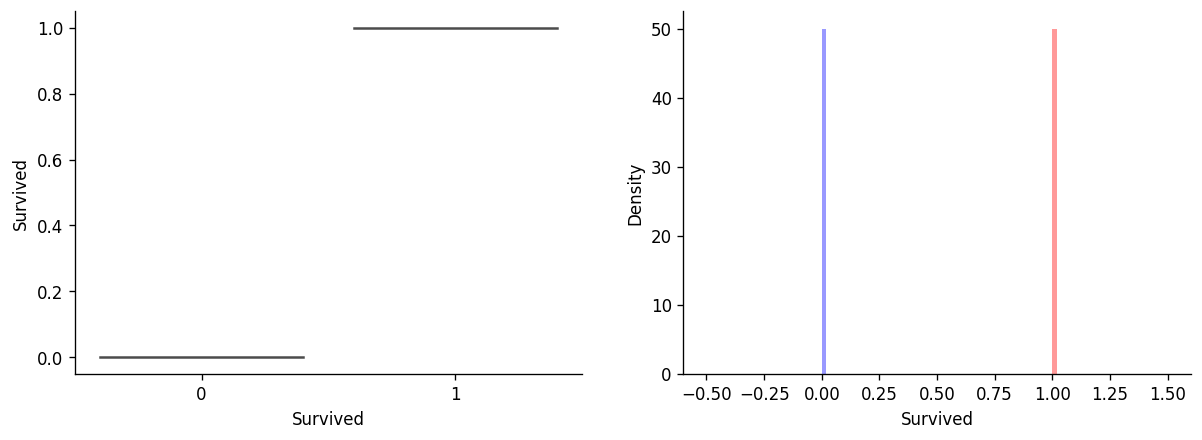

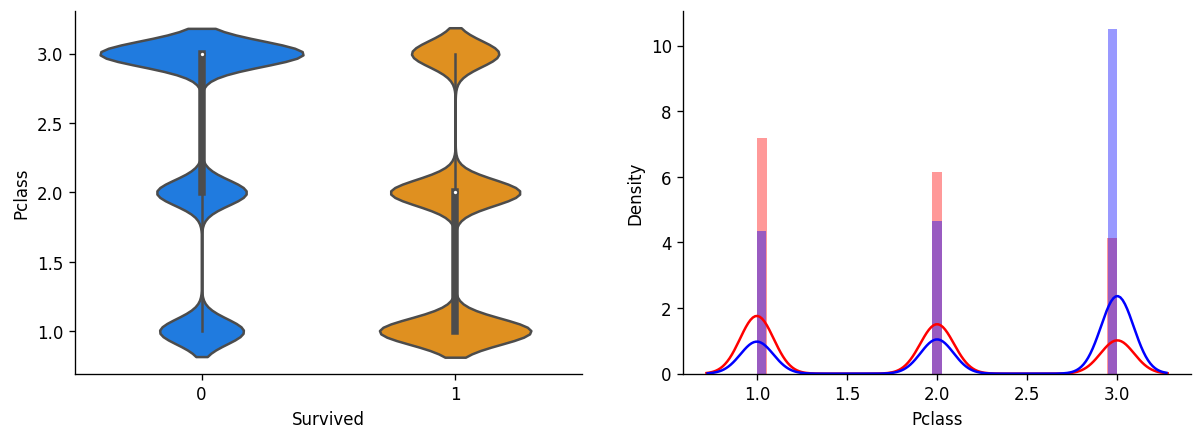

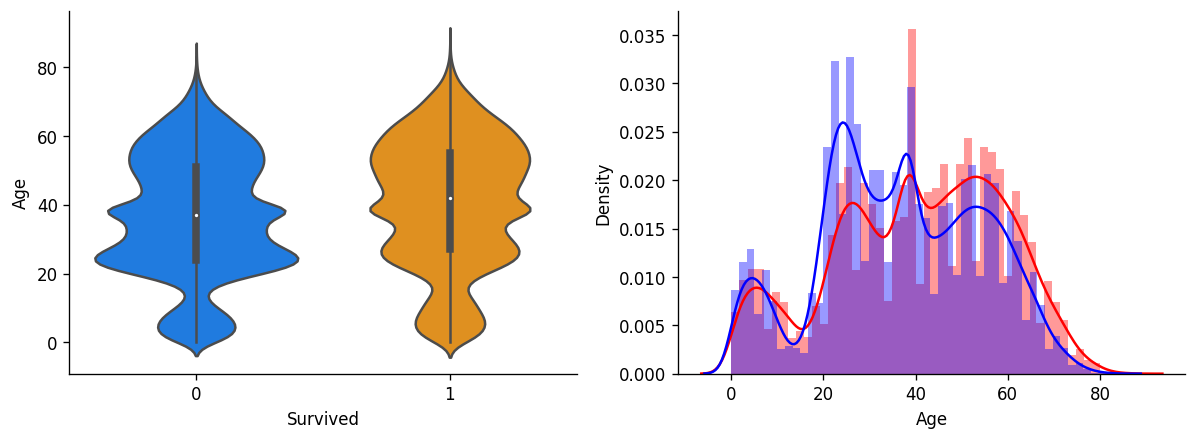

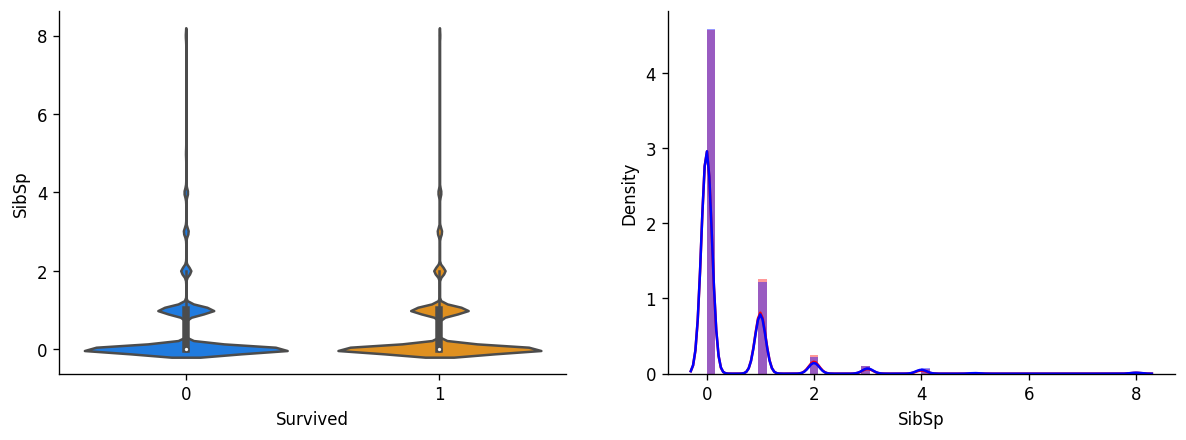

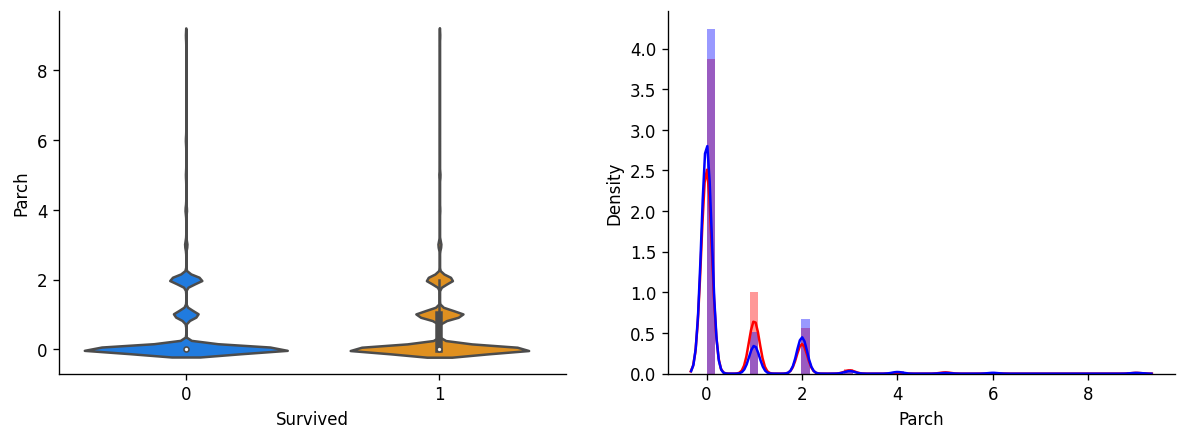

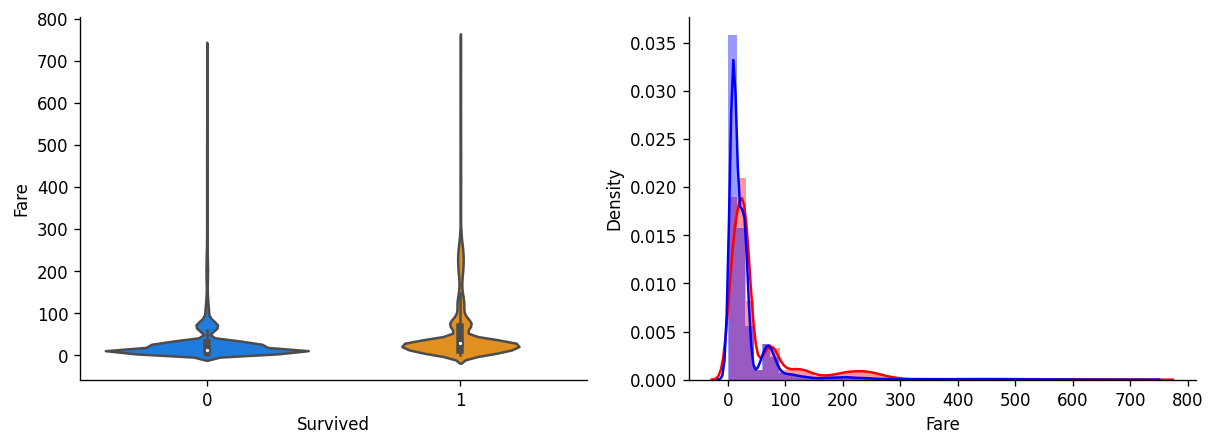

In [18]:
show_hist_by_target(train, num_columns)

변수들의 값에 대한 범주를 나눈 상태에서 사망한 사람들과 생존한 사람들의 분포를 확인하기 위한 그래프 

Maltin also said that more third-class passengers died than first or second-class passengers because anyone over the age of 13 was classed as an adult in 1912, meaning that teenage boys only made it onto the lifeboats after women and children.
https://www.irishcentral.com/roots/history/new-documentary-debunking-titanic-myths

In [19]:

def get_category_age(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

In [20]:
train['Age'].fillna(train['Age'].mean(), inplace=True)
train['Age'] = train['Age'].apply(lambda x : get_category_age(x))

In [21]:
def get_category_fare(fare):
    cat = ''
    if fare <= -1: cat = 'Unknown'
    elif fare <= 40: cat = 'Lower Class'
    elif fare < 150: cat = 'Middle Class'
    elif fare <= 500: cat = 'Rich'
    else : cat = 'Super Rich'
    
    return cat

[ 정 보 ]

1등실 : (응접실이 딸린 스위트 룸) $4,350

1등실 : (침실칸) $150

2등실 : 60$

3등실 : 15~40$

이 데이터 셋에서는 최소 요금이 0.68$, 최대 요금이 744.66$

In [22]:
train['Fare'].fillna(train['Fare'].mean(), inplace=True)
train['Fare'] = train['Fare'].apply(lambda x : get_category_fare(x))

In [23]:
def get_category_name(name):
    cat = ''
    if name <= -1: cat = 'Unknown'
    elif name <= 2: cat = 'highly rare'
    elif name <= 5: cat = 'rare'
    elif name <= 50: cat = 'slightly common'
    elif name <= 500: cat = 'common'
    elif name <= 1000: cat = 'moderately common'
    else : cat = 'highly common'
    
    return cat

- expand = True --> 데이터 프레임으로 반환한다
- expand = False --> 시리즈 또는 인덱스로 반환한다.
- '([A-Za-z]+)\,'는 정규표현식으로써, 공백으로 시작하고 ','로 끝나는 문자열을 추출할 때 사용 

In [24]:
train['FamName'] = train['Name'].str.extract('([A-Za-z]+)\,', expand=False)
FamName = train['FamName'].value_counts()
FamName = FamName.apply(lambda x : get_category_name(x))
train['FamName'] = train['FamName'].apply(lambda x: FamName[x])
print(train['FamName'].value_counts())

slightly common      33623
common               25255
highly rare          19463
rare                 16949
moderately common     3548
highly common         1162
Name: FamName, dtype: int64


In [25]:
def get_category_family(family):
    cat = ''
    if family <= -1: cat = 'Unknown'
    elif family <= 1: cat = 'Alone'
    elif family <= 2: cat = 'Couple'
    elif family <= 5: cat = 'Small'
    elif family <= 8: cat = 'Medium'
    elif family <= 12: cat = 'Big'
    else : cat = 'Very Big'
    
    return cat

In [26]:
train['FamSize'] = train['SibSp'] + train['Parch'] + 1
train['FamSize'] = train['FamSize'].apply(lambda x : get_category_family(x))

In [27]:
train['Ticket'] = train['Ticket'].apply(lambda x: x[0] if type(x) == str else 'Missing')

In [28]:
train['Cabin'] = train['Cabin'].apply(lambda x: x[0] if type(x) == str else 'Missing')

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   PassengerId  100000 non-null  int64 
 1   Survived     100000 non-null  int64 
 2   Pclass       100000 non-null  int64 
 3   Name         100000 non-null  object
 4   Sex          100000 non-null  object
 5   Age          100000 non-null  object
 6   SibSp        100000 non-null  int64 
 7   Parch        100000 non-null  int64 
 8   Ticket       100000 non-null  object
 9   Fare         100000 non-null  object
 10  Cabin        100000 non-null  object
 11  Embarked     99750 non-null   object
 12  Age band     96708 non-null   object
 13  Fare*Age     100000 non-null  object
 14  FamName      100000 non-null  object
 15  FamSize      100000 non-null  object
dtypes: int64(5), object(11)
memory usage: 12.2+ MB


In [30]:
train.dtypes[train.dtypes == 'object'].index.tolist()

['Name',
 'Sex',
 'Age',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Age band',
 'Fare*Age',
 'FamName',
 'FamSize']

In [31]:
object_columns = ['Age','FamName','FamSize','Cabin','Ticket','Fare']

column name: Age
column name: FamName
column name: FamSize
column name: Cabin
column name: Ticket
column name: Fare


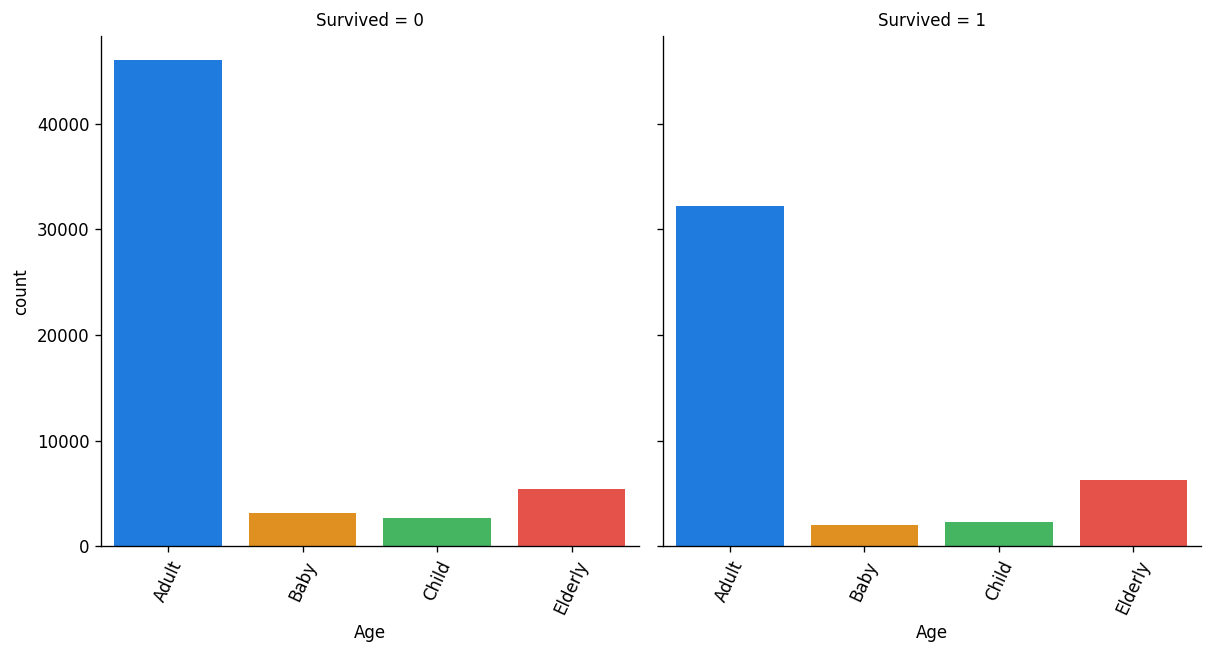

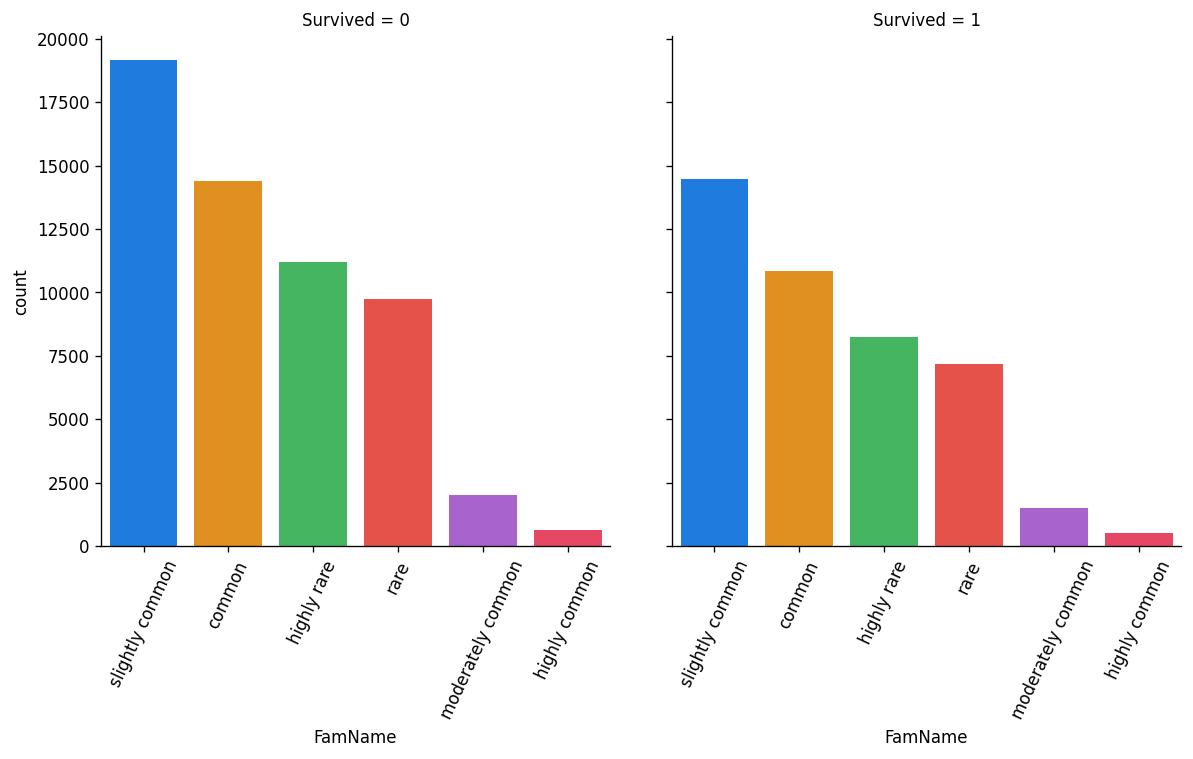

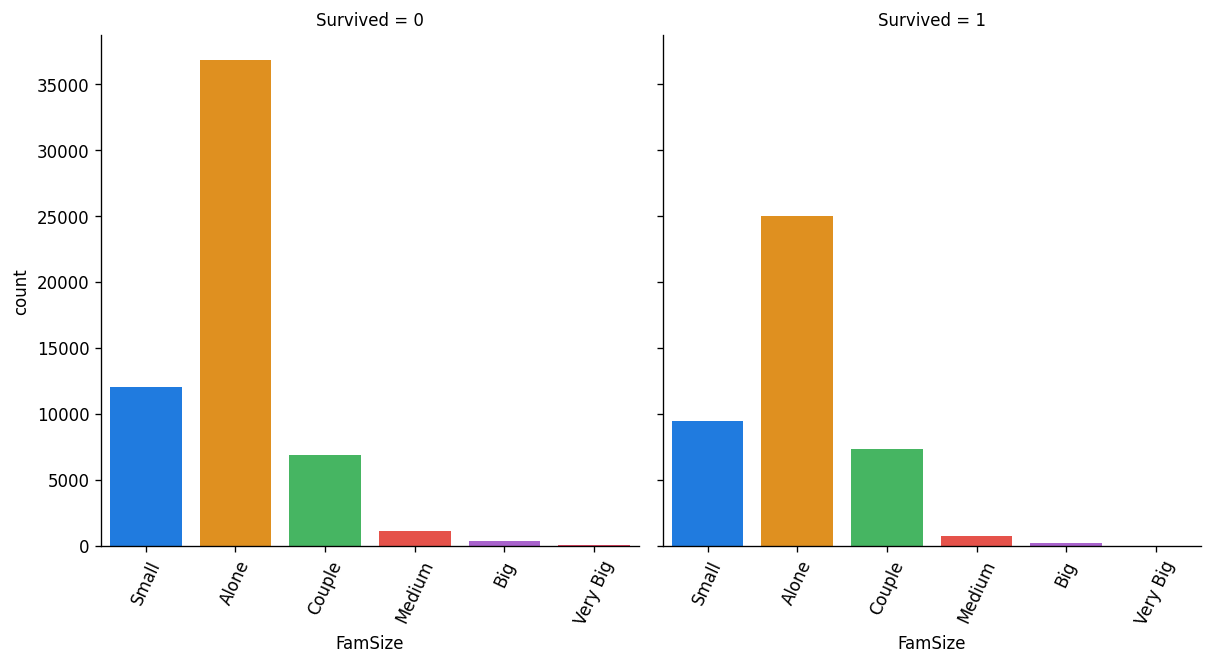

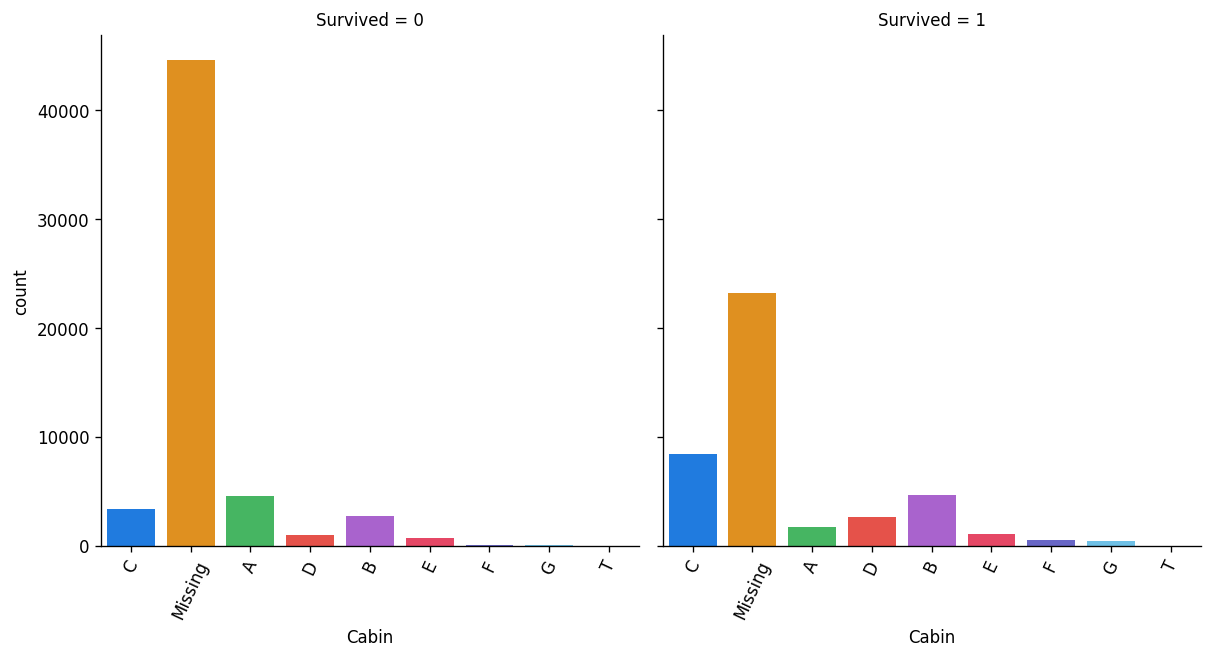

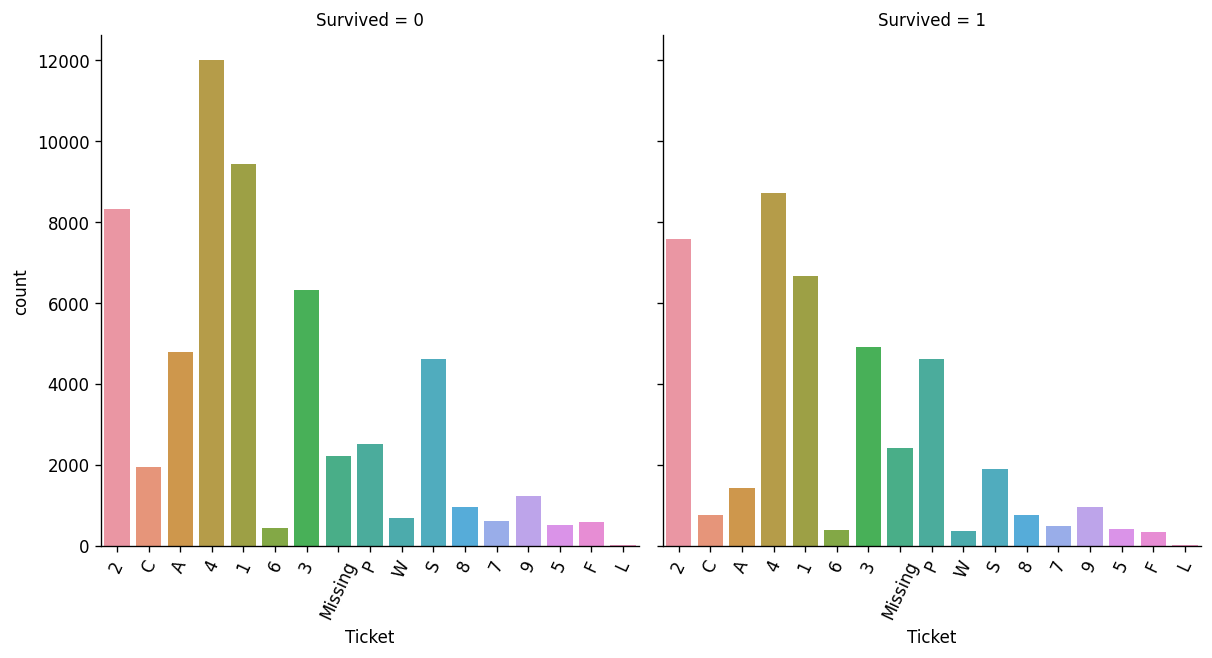

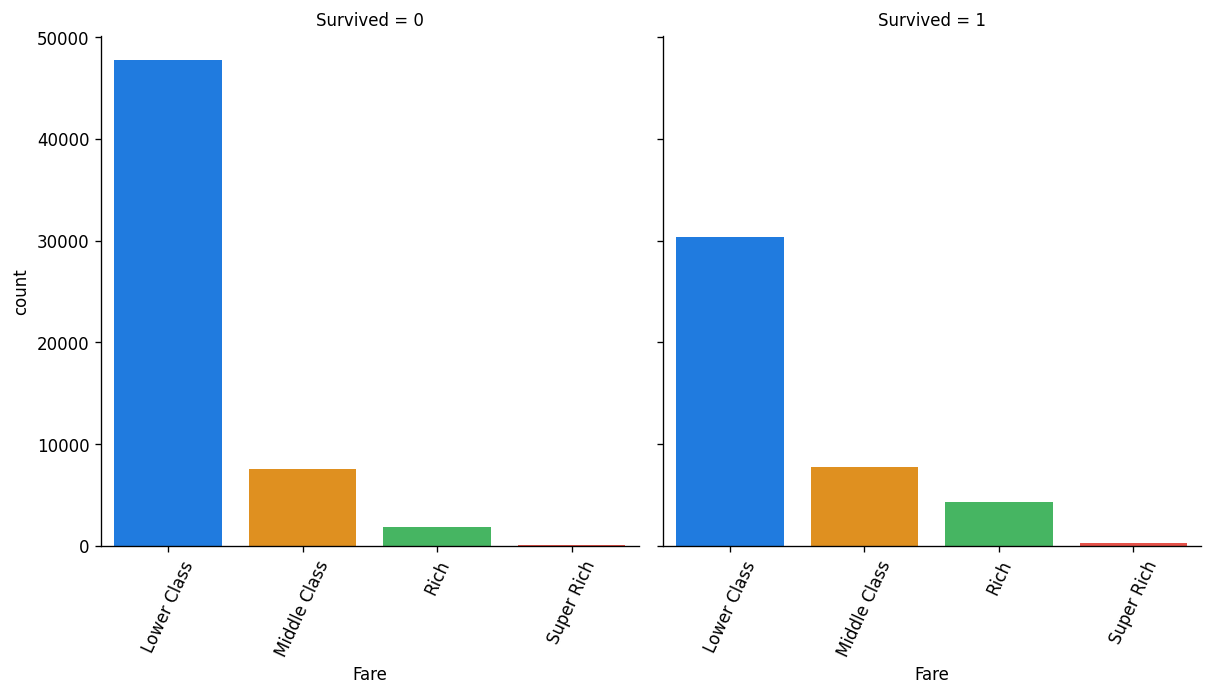

In [32]:
def show_category_by_target(df,columns):
    for column in columns:
        print('column name:',column)
        chart = sns.catplot(x=column, col='Survived', data=df, kind='count')
        chart.set_xticklabels(rotation=65)

show_category_by_target(train, object_columns)

In [33]:
train = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test= pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')

train.shape, test.shape, sample_submission.shape

((100000, 12), (100000, 11), (100000, 2))

**Embarked**

In [34]:
print(train['Embarked'].value_counts())

S    72139
C    22187
Q     5424
Name: Embarked, dtype: int64


In [35]:
Survived_0 = (train['Survived'] == 0)
Survived_1 = (train['Survived'] == 1)

# Embarked에 따른 사망 비율
print('_'*20)
print('Embarked에 따른 사망 비율') 
print('S :',train[Survived_0 & (train['Embarked'] == 'S')]['Embarked'].count() / train[Survived_0].shape[0])
print('C :',train[Survived_0 & (train['Embarked'] == 'C')]['Embarked'].count() / train[Survived_0].shape[0])
print('Q :',train[Survived_0 & (train['Embarked'] == 'Q')]['Embarked'].count() / train[Survived_0].shape[0])

# Embarked에 따른 사망 비율
print('_'*20)
print('Embarked에 따른 생존 비율') 
print('S :',train[Survived_0 & (train['Embarked'] == 'S')]['Embarked'].count() / train[Survived_0].shape[0])
print('C :',train[Survived_0 & (train['Embarked'] == 'C')]['Embarked'].count() / train[Survived_0].shape[0])
print('Q :',train[Survived_0 & (train['Embarked'] == 'Q')]['Embarked'].count() / train[Survived_0].shape[0])


# S : 사망 비율 / 생존 비율
print('_'*20)
print('S : 사망 비율 / 생존 비율')
print('사망 비율 : ',train[Survived_0 & (train['Embarked'] == 'S')]['Embarked'].count() / train[train['Embarked'] == 'S'].shape[0])
print('생존 비율 : ',train[Survived_1 & (train['Embarked'] == 'S')]['Embarked'].count() / train[train['Embarked'] == 'S'].shape[0])

# C : 사망 비율 / 생존 비율
print('_'*20)
print('C : 사망 비율 / 생존 비율')
print('사망 비율 : ',train[Survived_0 & (train['Embarked'] == 'C')]['Embarked'].count() / train[train['Embarked'] == 'C'].shape[0])
print('생존 비율 : ',train[Survived_1 & (train['Embarked'] == 'C')]['Embarked'].count() / train[train['Embarked'] == 'C'].shape[0])

# Q : 사망 비율 / 생존 비율
print('_'*20)
print(' Q : 사망 비율 / 생존 비율')
print('사망 비율 : ',train[Survived_0 & (train['Embarked'] == 'Q')]['Embarked'].count() / train[train['Embarked'] == 'Q'].shape[0])
print('생존 비율 : ',train[Survived_1 & (train['Embarked'] == 'Q')]['Embarked'].count() / train[train['Embarked'] == 'Q'].shape[0])

____________________
Embarked에 따른 사망 비율
S : 0.8631391325621222
C : 0.09642470205850487
Q : 0.038199419844126795
____________________
Embarked에 따른 생존 비율
S : 0.8631391325621222
C : 0.09642470205850487
Q : 0.038199419844126795
____________________
S : 사망 비율 / 생존 비율
사망 비율 :  0.6847059149697112
생존 비율 :  0.3152940850302888
____________________
C : 사망 비율 / 생존 비율
사망 비율 :  0.24870419615089917
생존 비율 :  0.7512958038491008
____________________
 Q : 사망 비율 / 생존 비율
사망 비율 :  0.403023598820059
생존 비율 :  0.596976401179941


In [36]:
# Embarked가 S일 경우 Fare의 평균값
print(train[train['Embarked'] == 'S']['Fare'].mean())
# Embarked가 C일 경우 Fare의 평균값 
print(train[train['Embarked'] == 'C']['Fare'].mean())
# Embarked가 Q일 경우 Fare의 평균값
print(train[train['Embarked'] == 'Q']['Fare'].mean())

33.200007772703934
71.54907285366073
73.38514771048744


Southampton에서 승선한 승객들이 대체로 탑승 요금이 적다는 부분에서 이들의 대부분이 3등실에 탔을 것이라고 예측할 수 있다.

In [37]:
titanic_embarked = train[['Embarked', 'Survived']].groupby('Embarked')['Survived'].value_counts().sort_index().unstack()
titanic_embarked['Survival rate'] = titanic_embarked[1] / (titanic_embarked[0] + titanic_embarked[1]) * 100

embarked = train['Embarked'].value_counts().sort_index()

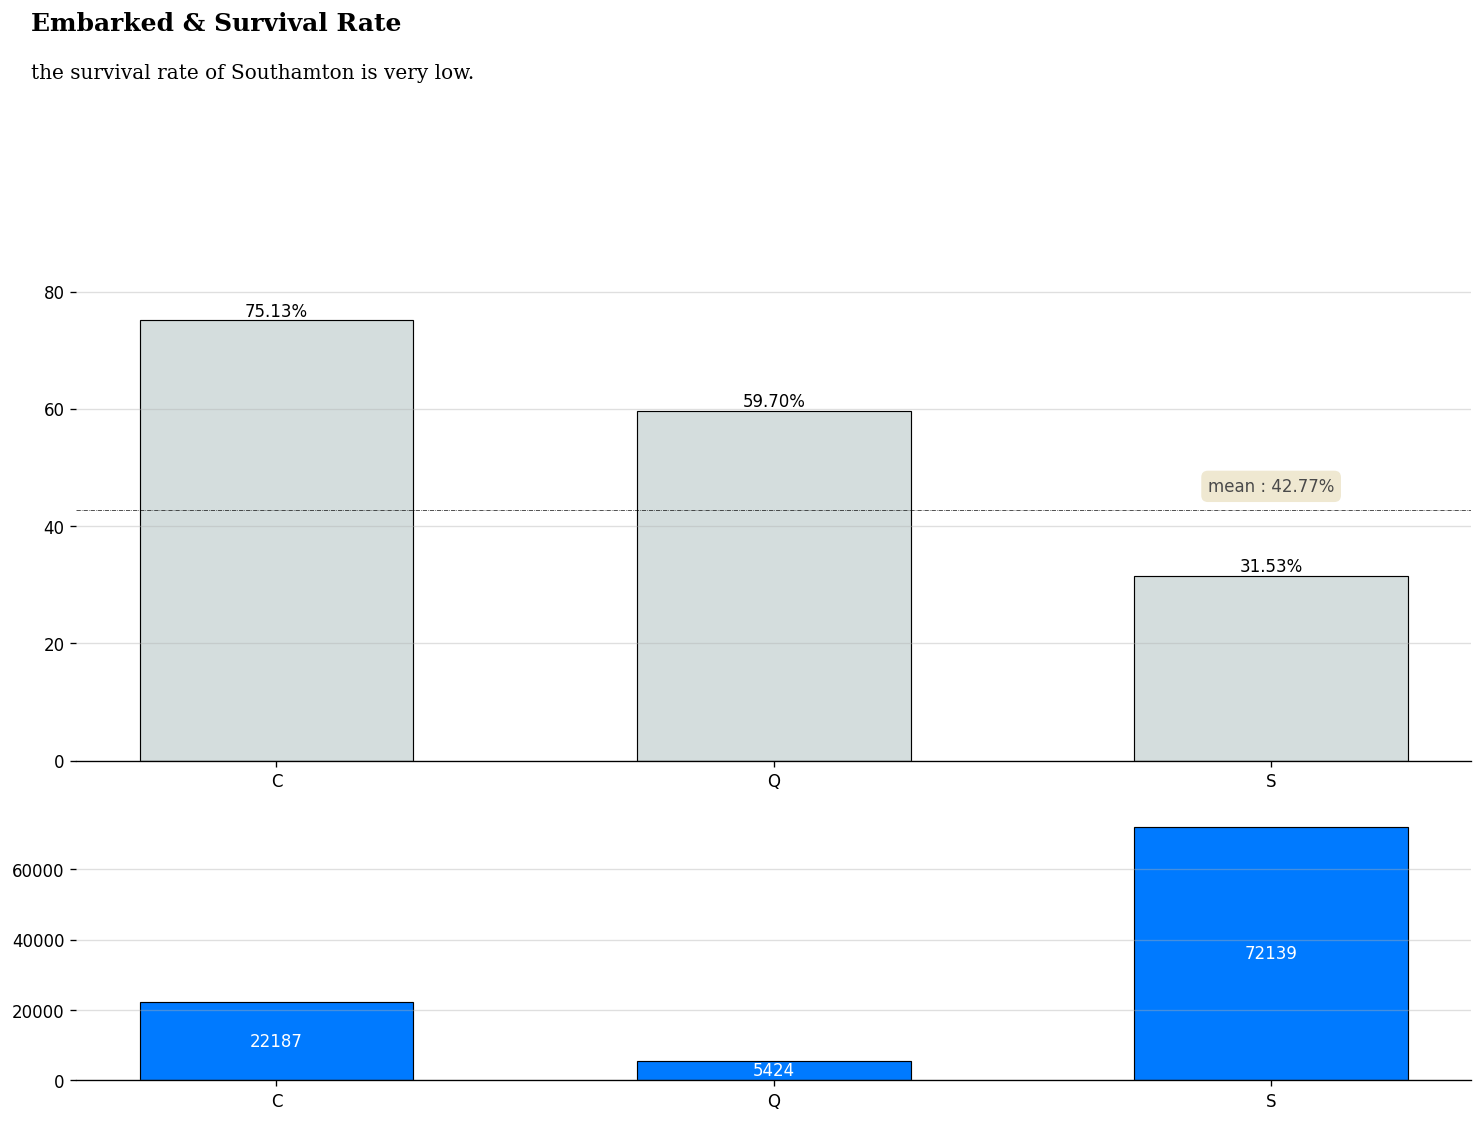

In [38]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:-1,:])

color_map = ['#d4dddd' for _ in range(3)]
#color_map[2] = light_palette[2]


bars = ax.bar(titanic_embarked['Survival rate'].index, titanic_embarked['Survival rate'], 
       color=color_map, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax.spines[["top","right","left"]].set_visible(False)
ax.bar_label(bars, fmt='%.2f%%')


# mean line + annotation
mean = train['Survived'].mean() *100
ax.axhline(mean ,color='black', linewidth=0.4, linestyle='dashdot')
ax.annotate(f"mean : {mean :.4}%", 
            xy=('S', mean + 4),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))
    



ax.set_yticks(np.arange(0, 100, 20))
ax.grid(axis='y', linestyle='-', alpha=0.4)
ax.set_ylim(0, 100)


ax_bottom = fig.add_subplot(gs[-1,:])
bars = ax_bottom.bar(embarked.index, embarked, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax_bottom.spines[["top","right","left"]].set_visible(False)
ax_bottom.bar_label(bars, fmt='%d', label_type='center', color='white')
ax_bottom.grid(axis='y', linestyle='-', alpha=0.4)

# Title & Subtitle    
fig.text(0.1, 1, 'Embarked & Survival Rate', fontsize=15, fontweight='bold', fontfamily='serif', ha='left')
fig.text(0.1, 0.96, 'the survival rate of Southamton is very low.', fontsize=12, fontweight='light', fontfamily='serif', ha='left')

plt.show()

**Ticket**

In [39]:
set(train.Ticket.map(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else 'XX'))

{'A.',
 'A./5.',
 'A.5.',
 'A/4',
 'A/4.',
 'A/5',
 'A/5.',
 'A/S',
 'A4.',
 'AQ/3.',
 'AQ/4',
 'C',
 'C.A.',
 'C.A./SOTON',
 'CA',
 'CA.',
 'F.C.',
 'F.C.C.',
 'Fa',
 'LP',
 'P/PP',
 'PC',
 'PP',
 'S.C./A.4.',
 'S.C./PARIS',
 'S.O./P.P.',
 'S.O.C.',
 'S.O.P.',
 'S.P.',
 'S.W./PP',
 'SC',
 'SC/A.3',
 'SC/A4',
 'SC/AH',
 'SC/PARIS',
 'SC/Paris',
 'SCO/W',
 'SO/C',
 'SOTON/O.Q.',
 'SOTON/O2',
 'SOTON/OQ',
 'STON/O',
 'STON/O2.',
 'STON/OQ.',
 'SW/PP',
 'W./C.',
 'W.E.P.',
 'W/C',
 'WE/P',
 'XX'}

In [40]:
train['TicketType'] = train.Ticket.fillna('XX')
train['TicketType'] = train.TicketType.map(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else 'XX')
print(set(train.TicketType))

{'A./5.', 'STON/O2.', 'XX', 'LP', 'SC/Paris', 'SOTON/O.Q.', 'SC/A.3', 'PC', 'SO/C', 'S.P.', 'SW/PP', 'W./C.', 'S.C./PARIS', 'A/S', 'STON/O', 'SOTON/O2', 'SC/AH', 'A/5.', 'A/4', 'SC/A4', 'PP', 'Fa', 'A.5.', 'A4.', 'A/4.', 'W/C', 'AQ/3.', 'S.C./A.4.', 'SC', 'C', 'WE/P', 'S.O.P.', 'SCO/W', 'SC/PARIS', 'A.', 'C.A./SOTON', 'S.O.C.', 'C.A.', 'P/PP', 'STON/OQ.', 'S.W./PP', 'S.O./P.P.', 'A/5', 'CA.', 'SOTON/OQ', 'CA', 'F.C.C.', 'AQ/4', 'W.E.P.', 'F.C.'}


In [41]:
train['TicketType'] = train['TicketType'].str.lower()

import re
train['TicketType'] = train.TicketType.map(lambda x : re.sub("[^\w\s]+","",x))
set(train.TicketType.to_list())

{'a',
 'a4',
 'a5',
 'aq3',
 'aq4',
 'as',
 'c',
 'ca',
 'casoton',
 'fa',
 'fc',
 'fcc',
 'lp',
 'pc',
 'pp',
 'ppp',
 'sc',
 'sca3',
 'sca4',
 'scah',
 'scow',
 'scparis',
 'soc',
 'sop',
 'sopp',
 'sotono2',
 'sotonoq',
 'sp',
 'stono',
 'stono2',
 'stonoq',
 'swpp',
 'wc',
 'wep',
 'xx'}

In [42]:
train.TicketType.value_counts()/train.shape[0]
print(train['TicketType'].unique().shape)

(35,)


In [43]:
titanic_ticket_type = train[['TicketType','Survived']].groupby('TicketType')['Survived'].value_counts().sort_index().unstack()
titanic_ticket_type['Survival rate'] = titanic_ticket_type[1] / (titanic_ticket_type[0] + titanic_ticket_type[1]) * 100
ticket_type = train['TicketType'].value_counts().sort_index()
print(titanic_ticket_type.shape)

(35, 3)


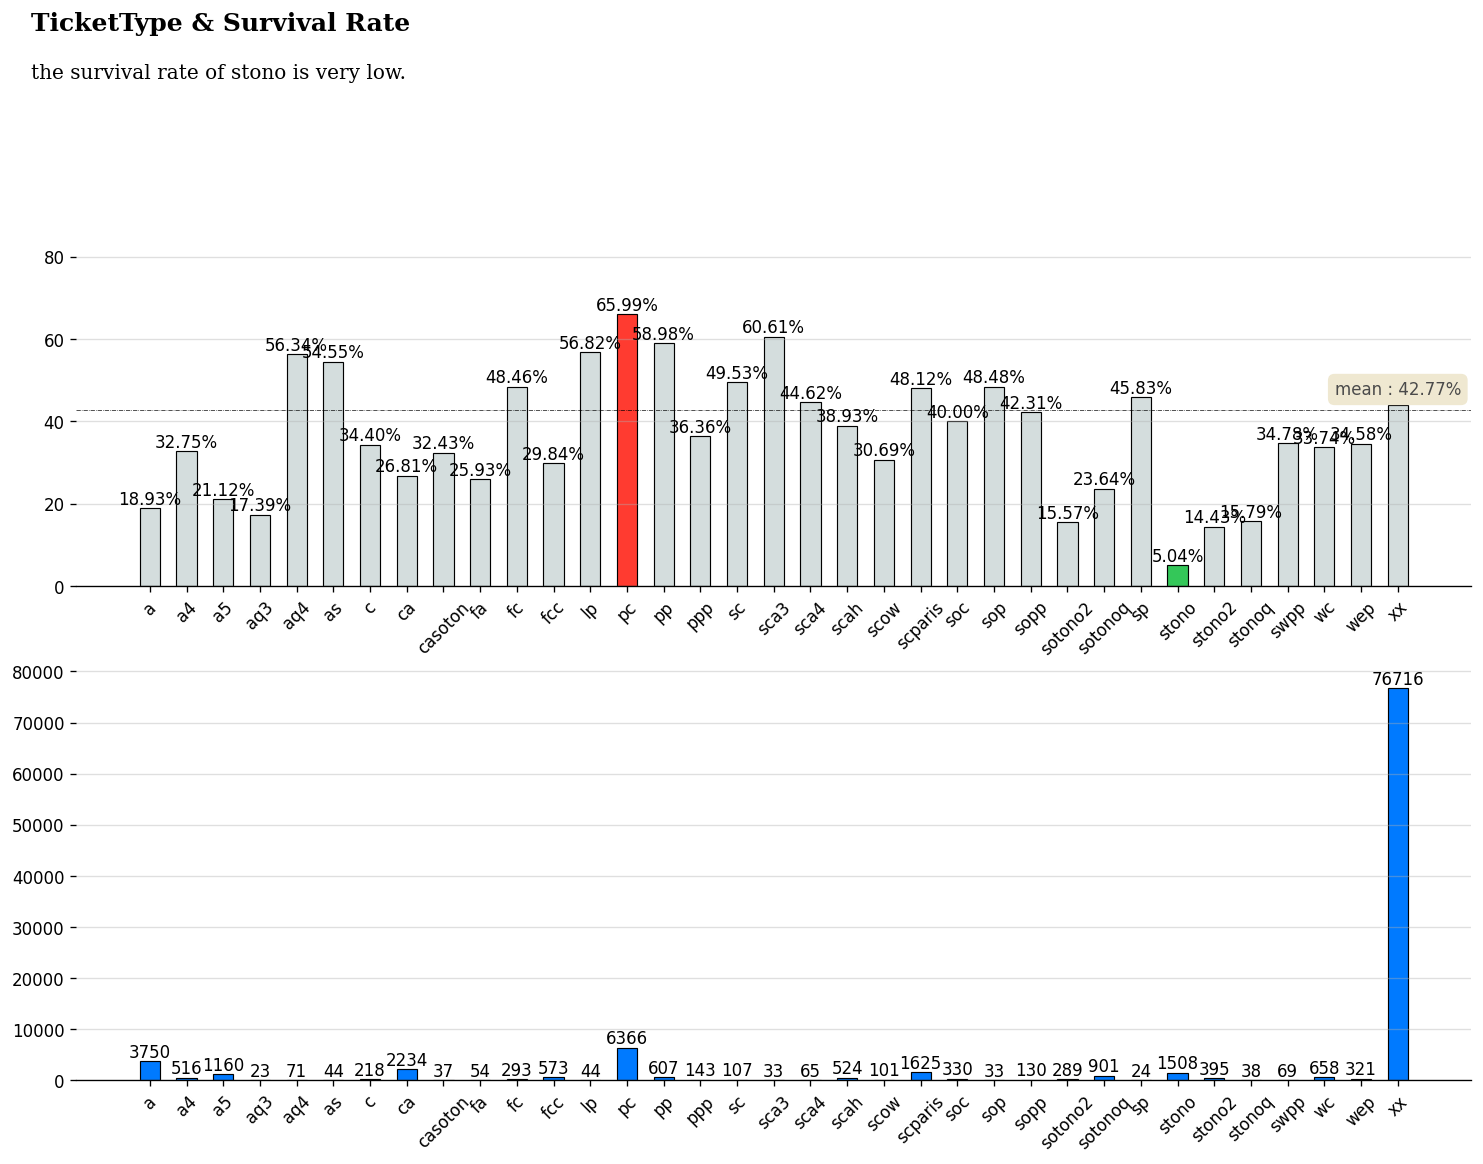

In [44]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3)
ax = fig.add_subplot(gs[:-1,:])

color_map = ['#d4dddd' for _ in range(35)]
color_map[28] = light_palette[2]
color_map[13] = light_palette[3]


bars = ax.bar(titanic_ticket_type['Survival rate'].index, titanic_ticket_type['Survival rate'], 
       color=color_map, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax.spines[["top","right","left"]].set_visible(False)
ax.bar_label(bars, fmt='%.2f%%', label_type='edge')


# mean line + annotation
mean = train['Survived'].mean() *100
ax.axhline(mean ,color='black', linewidth=0.4, linestyle='dashdot')
ax.xaxis.set_tick_params(rotation=45) # x축 각도 조절
ax.annotate(f"mean : {mean :.4}%", 
            xy=('xx', mean + 5),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))
    



ax.set_yticks(np.arange(0, 100, 20))
ax.grid(axis='y', linestyle='-', alpha=0.4)
ax.set_ylim(0, 100)


ax_bottom = fig.add_subplot(gs[-1,:])
bars = ax_bottom.bar(ticket_type.index, ticket_type, width=0.55, 
       edgecolor='black', 
       linewidth=0.7)

ax_bottom.spines[["top","right","left"]].set_visible(False)
ax_bottom.bar_label(bars, fmt='%d', label_type='edge', color='black')
ax_bottom.grid(axis='y', linestyle='-', alpha=0.4)
ax_bottom.xaxis.set_tick_params(rotation=45)

# Title & Subtitle    
fig.text(0.1, 1, 'TicketType & Survival Rate', fontsize=15, fontweight='bold', fontfamily='serif', ha='left')
fig.text(0.1, 0.96, 'the survival rate of stono is very low.', fontsize=12, fontweight='light', fontfamily='serif', ha='left')

plt.show()

그래프를 보면 생존률이 높은 티켓 종류들과 생존률이 낮은 티켓 종류들이 있다는 것을 알 수 있다. 생존률의 차이에 대한 원인을 빈부 격차라고 가정하고 티켓 종류별 Pclass의 비율을 분석해보았다.

In [45]:
print(pd.crosstab(index = train.TicketType, columns=train.Pclass, normalize='index'))

Pclass             1         2         3
TicketType                              
a           0.002933  0.262933  0.734133
a4          0.265504  0.327519  0.406977
a5          0.135345  0.252586  0.612069
aq3         0.130435  0.217391  0.652174
aq4         0.253521  0.295775  0.450704
as          0.340909  0.272727  0.386364
c           0.142202  0.348624  0.509174
ca          0.183080  0.287825  0.529096
casoton     0.216216  0.432432  0.351351
fa          0.092593  0.277778  0.629630
fc          0.460751  0.276451  0.262799
fcc         0.202443  0.312391  0.485166
lp          0.045455  0.522727  0.431818
pc          0.945806  0.032988  0.021206
pp          0.217463  0.377265  0.405272
ppp         0.391608  0.230769  0.377622
sc          0.364486  0.280374  0.355140
sca3        0.272727  0.484848  0.242424
sca4        0.292308  0.369231  0.338462
scah        0.181298  0.410305  0.408397
scow        0.118812  0.356436  0.524752
scparis     0.366769  0.306462  0.326769
soc         0.36

티켓 종류별 1,2등급의 평균 비율

In [46]:
num_1_ratio = pd.crosstab(index = train.TicketType, columns = train.Pclass, normalize='index')[1].mean(axis=0)
num_2_ratio = pd.crosstab(index = train.TicketType, columns = train.Pclass, normalize='index')[2].mean(axis=0)

upper_class_ratio = num_1_ratio + num_2_ratio

- 티켓 종류별 pclass의 비율 분포도를 나타내는 그래프

- 빨간색 선은 1등급 + 2등급 클래스의 평균 비율을 나타낸다.


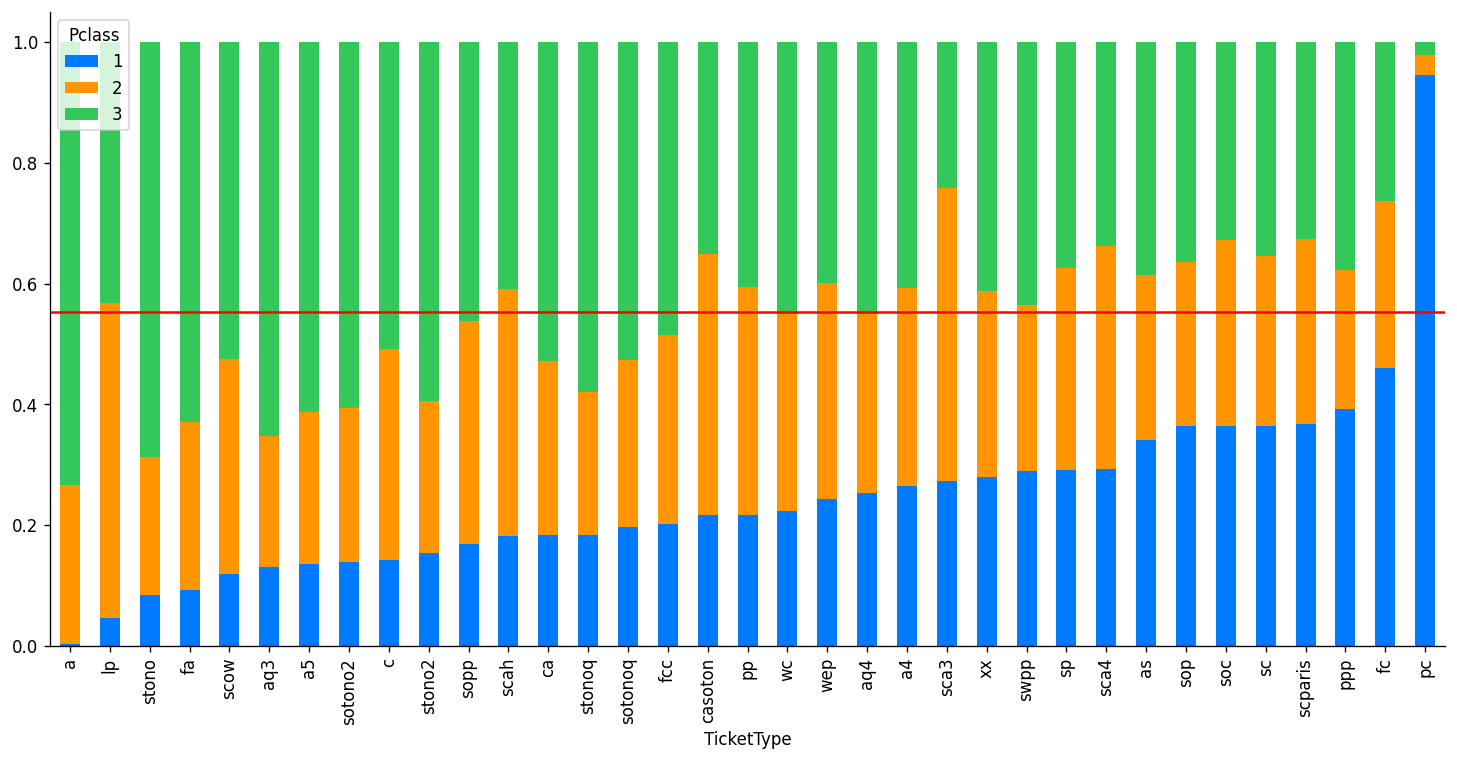

In [47]:
pd.crosstab(index = train.TicketType, columns = train.Pclass, normalize = 'index').sort_values(by = 1).plot.bar(figsize = (15 ,7), stacked = True)

plt.axhline(y = upper_class_ratio, color = 'r', linestyle = '-')

- 빨간선은 평균 사망 비율을 나타낸다.

- 1, 2등급 클래스 비율이 높은 티켓 종류들은 1, 2등급 클래스 비율이 낮은 티켓 종류들의 비해 사망률이 낮다는 것을 알 수 있다.

- 이를 통해 부유한 사람들의 생존률이 가난한 사람들의 생존률 보다 높다는 결과를 도출해낼 수 있다.

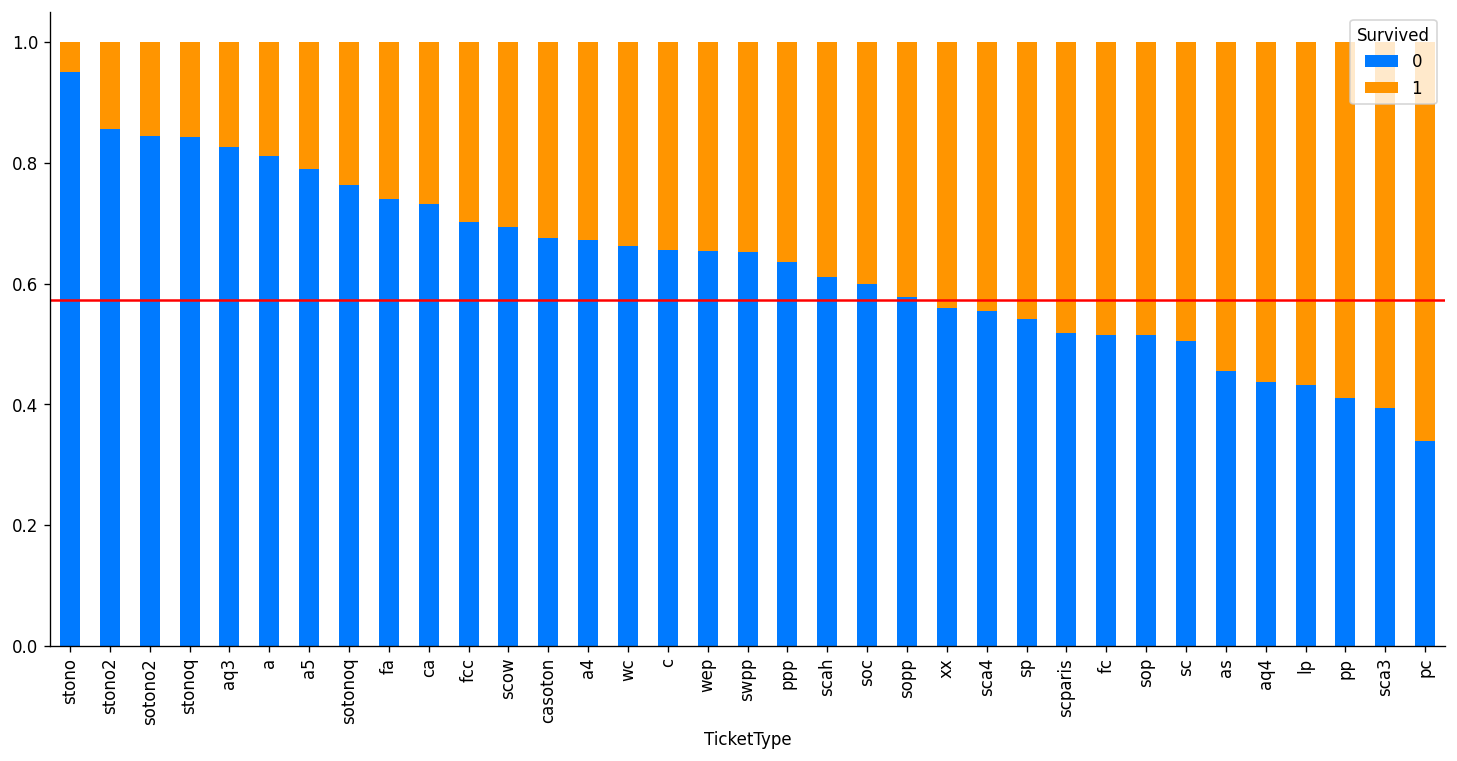

In [48]:
pd.crosstab(index = train.TicketType, columns = train.Survived, normalize = 'index').sort_values(by=1).plot.bar(figsize=(15, 7), stacked = True)

death_mean_rate = 1 - train['Survived'].mean()

plt.axhline(y = death_mean_rate ,color = 'r', linestyle = '-')

In [49]:
train['TT_bucket'] = train.TicketType.map(lambda x:0 if x == 'pc' else 3 if x in ['stono', 'stono2', 'sotono2', 'stonoq', 'aq3', 'a', 'a5', 'sotonoq', 'fa', 'ca'] \
                                          else 2 if x in ['fcc', 'scow', 'caston', 'wc', 'c', 'wep', 'swpp', 'ppp', 'scah', 'soc', 'sopp'] else 1)

train['TT_bucket'].value_counts()

1    80215
3    10352
0     6366
2     3067
Name: TT_bucket, dtype: int64

- 1등급 비율을 기준으로 하여 범주화를 했습니다.

- 0 에서 3으로 갈수록 3등급 클래스의 비율이 높은 값입니다.

- 0 에서 3으로 갈수록 생존률이 낮음을 확인할 수 있습니다.

- 1등급 비율이 높은 티켓일수록 생존률이 높다는 것을 알 수 있고 이를 통하여 부유한 사람들의 생존률이 높다는 것을 알 수 있습니다.

<AxesSubplot:xlabel='TT_bucket'>

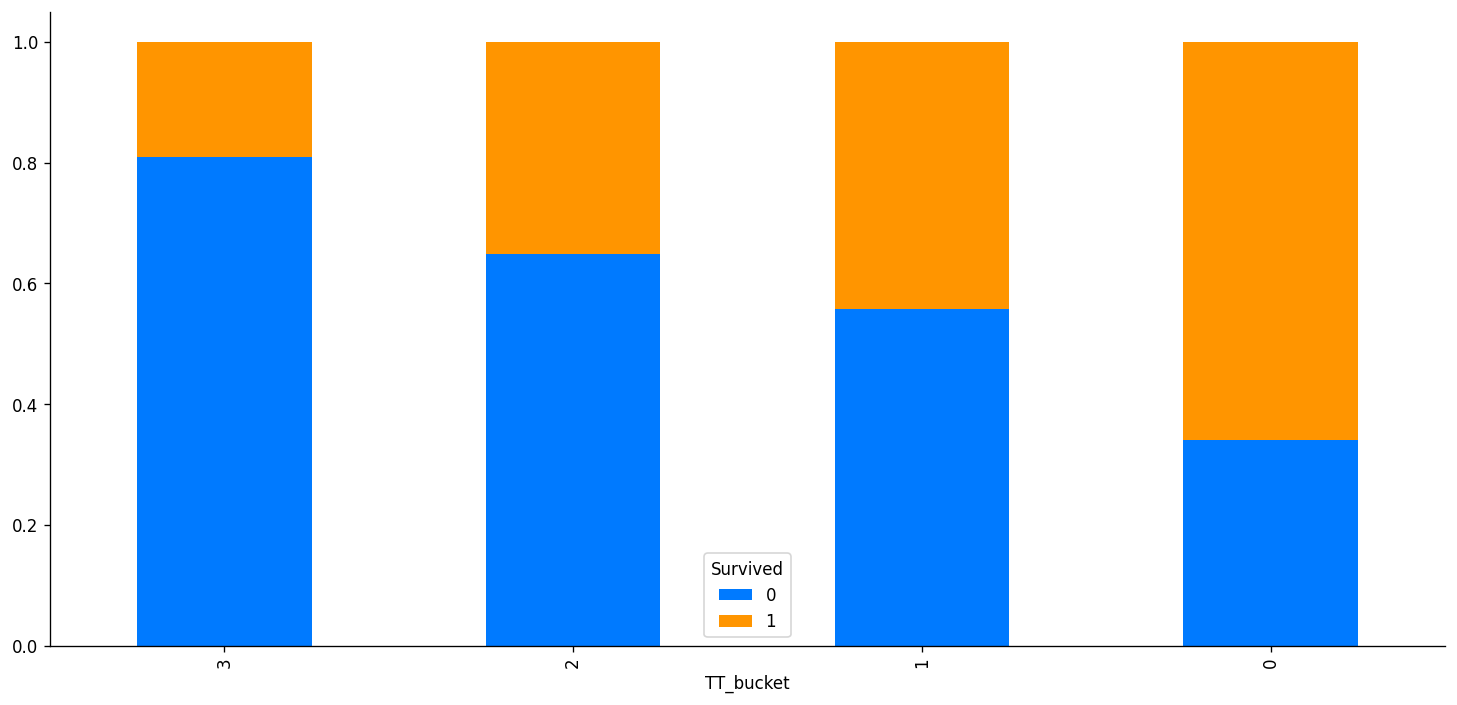

In [50]:
pd.crosstab(index = train.TT_bucket, columns = train.Survived, normalize = 'index').sort_values(by = 1).plot.bar(figsize = (15, 7), stacked = True)

**Fare**

Fare 값의 분포를 확인하면 비대칭 데이터셋이라는 것을 확인할 수 있습니다. 요금이 Pclass에 따라 달라지는지 확인한 후 승객 등급에 따라 누락된 값을 처리하겠습니다.
또한 두꺼운 꼬리(heavy tail) 분포와 이상치로 인한 요금 변동을 제어하기 위해 로그 변환을 수행하겠습니다.
그리고 요금에는 일부 값이 1보다 작은 값이 있으므로 ln(fare)을 수행할 시 음수가 될 수 있기 때문에 ln(1 + Fare) 변환을 수행합니다.

In [51]:
print(train.Fare.describe())

count    99866.00000
mean        43.92933
std         69.58882
min          0.68000
25%         10.04000
50%         24.46000
75%         33.50000
max        744.66000
Name: Fare, dtype: float64


박스 플롯 그래프를 확인하면 요금은 pclass에 의해 결정됨을 알 수 있습니다.

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

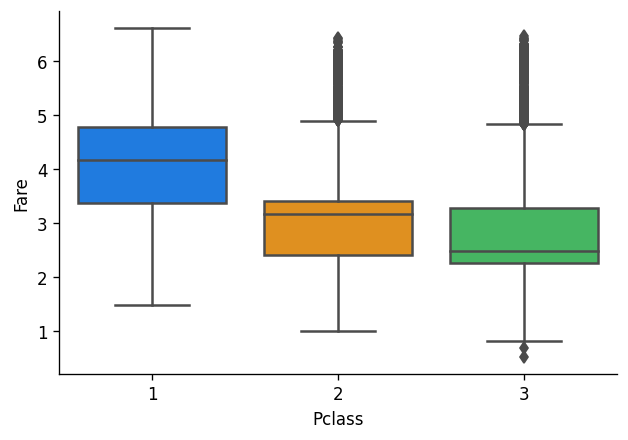

In [52]:
sns.boxplot(x = train.Pclass, y = np.log(1+train.Fare))

로그 변환을 통해 왜도를 제거한 다음 결측치 제거를 수행합니다. 각각의 결측치의 Pclass값에 따라서 그 값에 일치하는 Pclass 중위값으로 대체하는 작업을 수행합니다.

In [53]:
FareByClass = pd.crosstab(index = train.Pclass, columns = 'MedianFare', values = np.log(1+train.Fare), aggfunc = 'median').to_dict()['MedianFare']

FareByClass

{1: 4.167904765330129, 2: 3.1663185741295248, 3: 2.481567748522486}

In [54]:
train['LnFare'] = np.log(1 + train['Fare'])

train['LnFare'].fillna(train.Pclass.map(FareByClass), inplace=True)

# 결측치가 Pclass 중위값으로 대체되었다.
train.loc[:,['Fare','LnFare']][train.Fare.isna()]

,Fare,LnFare
39,NaN,3.166319
1404,NaN,4.167905
1909,NaN,3.166319
1999,NaN,2.481568
3885,NaN,4.167905
3994,NaN,3.166319
4279,NaN,2.481568
4289,NaN,3.166319
5007,NaN,2.481568
5407,NaN,3.166319


<AxesSubplot:xlabel='LnFare', ylabel='Density'>

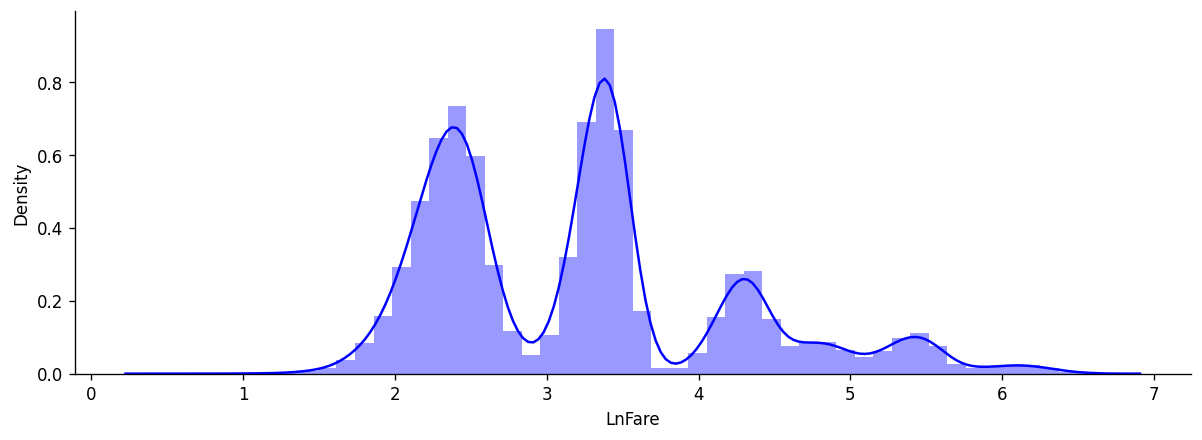

In [55]:
fig, axs = plt.subplots(figsize = (12, 4), nrows=1, ncols=1, squeeze=False)
sns. distplot(train['LnFare'], color='blue', ax=axs[0][0])

<a id='handling_missing_values'></a>
### (3) Handling Missing Values
- Let's fill with some value in each column.
> *Important Note:* This idea is from [TPS Apr 2021 LightGBM CV](https://www.kaggle.com/jmargni/tps-apr-2021-lightgbm-cv). Thank you. 


In [56]:
train_df = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')

pseudo_labels = pd.read_csv('../input/pseudo-label-file/pseudo_label.csv')
test_df[TARGET] = pseudo_labels[TARGET]

train_df.shape, test_df.shape, sample_submission.shape

((100000, 12), (100000, 12), (100000, 2))

In [57]:
temp = pd.concat([train_df, test_df]).reset_index(drop=True)

Age 변수 전처리

In [58]:
temp['Age'] = temp['Age'].fillna(temp['Age'].median())

pd.cut(X, bins, labels) 를 이용한 연속형 변수의 여러개 구간별 범주화 

In [59]:
temp["Age_bucket"] = pd.cut(temp['Age'], 9,
                            labels = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89"])

Embarked 변수 전처리

In [60]:
temp['Embarked'] = temp['Embarked'].fillna('N')

Cabin 변수 전처리

In [61]:
# Cabin이 할당된 사람들과 그렇지 않은 사람들을 구분하기 위한 변수
temp['CabinNotAlloted'] = temp.Cabin.isna().astype(int)
print(temp['CabinNotAlloted'].value_counts()/temp.shape[0])

1    0.693485
0    0.306515
Name: CabinNotAlloted, dtype: float64


In [62]:
temp['Cabin'] = temp.Cabin.str[:1]
temp['Cabin'].fillna('X')

0         C
1         X
2         X
3         X
4         X
         ..
199995    X
199996    X
199997    X
199998    B
199999    E
Name: Cabin, Length: 200000, dtype: object

**티켓 변수 전처리**

- \w - 문자+숫자(alphanumeric)와 매치
- \s - whitespace 문자와 매치
- 문자 클래스 안에 ^ 메타 문자를 사용할 경우에는 반대(not)라는 의미를 갖는다.
- replace('[^\w\s]','') --> 문자+숫자+공백문자를 제외한 문자를 공백으로 바꾼다.

In [63]:
set(temp.Ticket.map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'XX'))

{'A.',
 'A./5.',
 'A.5.',
 'A/4',
 'A/4.',
 'A/5',
 'A/5.',
 'A/S',
 'A4.',
 'AQ/3.',
 'AQ/4',
 'C',
 'C.A.',
 'C.A./SOTON',
 'CA',
 'CA.',
 'F.C.',
 'F.C.C.',
 'Fa',
 'LP',
 'P/PP',
 'PC',
 'PP',
 'S.C./A.4.',
 'S.C./PARIS',
 'S.O./P.P.',
 'S.O.C.',
 'S.O.P.',
 'S.P.',
 'S.W./PP',
 'SC',
 'SC/A.3',
 'SC/A4',
 'SC/AH',
 'SC/PARIS',
 'SC/Paris',
 'SCO/W',
 'SO/C',
 'SOTON/O.Q.',
 'SOTON/O2',
 'SOTON/OQ',
 'STON/O',
 'STON/O2.',
 'STON/OQ.',
 'SW/PP',
 'W./C.',
 'W.E.P.',
 'W/C',
 'WE/P',
 'XX'}

In [64]:
temp['TicketType'] = temp.Ticket.fillna('XX')
temp['TicketType'] = temp.TicketType.map(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else 'XX')
print(set(temp.TicketType))

{'A./5.', 'STON/O2.', 'XX', 'LP', 'SC/Paris', 'SOTON/O.Q.', 'SC/A.3', 'PC', 'SO/C', 'S.P.', 'SW/PP', 'W./C.', 'S.C./PARIS', 'A/S', 'STON/O', 'SOTON/O2', 'SC/AH', 'A/5.', 'A/4', 'SC/A4', 'PP', 'Fa', 'A.5.', 'A4.', 'A/4.', 'W/C', 'AQ/3.', 'S.C./A.4.', 'SC', 'C', 'WE/P', 'S.O.P.', 'SCO/W', 'SC/PARIS', 'A.', 'C.A./SOTON', 'S.O.C.', 'C.A.', 'P/PP', 'STON/OQ.', 'S.W./PP', 'S.O./P.P.', 'A/5', 'CA.', 'SOTON/OQ', 'CA', 'F.C.C.', 'AQ/4', 'W.E.P.', 'F.C.'}


In [65]:
temp['TicketType'] = temp['TicketType'].str.lower()

import re
temp['TicketType'] = temp.TicketType.map(lambda x: re.sub("[^\w\s]+","",x))
set(temp.TicketType.to_list())

{'a',
 'a4',
 'a5',
 'aq3',
 'aq4',
 'as',
 'c',
 'ca',
 'casoton',
 'fa',
 'fc',
 'fcc',
 'lp',
 'pc',
 'pp',
 'ppp',
 'sc',
 'sca3',
 'sca4',
 'scah',
 'scow',
 'scparis',
 'soc',
 'sop',
 'sopp',
 'sotono2',
 'sotonoq',
 'sp',
 'stono',
 'stono2',
 'stonoq',
 'swpp',
 'wc',
 'wep',
 'xx'}

In [66]:
temp['TT_bucket'] = temp.TicketType.map(lambda x:0 if x == 'pc' else 3 if x in ['stono', 'stono2', 'sotono2', 'stonoq', 'aq3', 'a', 'a5', 'sotonoq', 'fa', 'ca'] \
                                          else 2 if x in ['fcc', 'scow', 'caston', 'wc', 'c', 'wep', 'swpp', 'ppp', 'scah', 'soc', 'sopp'] else 1)

로그 변환한 Fare 변수 전처리

In [67]:
FareByClass = pd.crosstab(index = temp.Pclass, columns = 'MedianFare', values = np.log(1+temp.Fare), aggfunc = 'median').to_dict()['MedianFare']
FareByClass

{1: 4.2878533084066195, 2: 3.122364924487357, 3: 2.512035317176253}

In [68]:
temp['LnFare'] = np.log(1+temp['Fare'])

temp['LnFare'].fillna(temp.Pclass.map(FareByClass), inplace = True)

Family Size

In [69]:
temp['FamilySize'] = temp['SibSp'] + temp['Parch'] + 1

In [70]:
def family_size(x):
    if x == 1:
        return "alone"
    else:
        return "notalone"

In [71]:
temp['Group'] = temp['FamilySize'].apply(family_size)
print(temp['Group'].value_counts())

alone       116448
notalone     83552
Name: Group, dtype: int64


Drop the unnecessary columns

In [72]:
temp.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_bucket',
       'CabinNotAlloted', 'TicketType', 'TT_bucket', 'LnFare', 'FamilySize',
       'Group'],
      dtype='object')

In [73]:
temp.select_dtypes(exclude=['float64','int64','bool']).columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age_bucket',
       'TicketType', 'Group'],
      dtype='object')

In [74]:
np.where((temp.dtypes != 'float64')&(temp.dtypes != 'int64')&(temp.dtypes != 'bool'))[0].tolist()

[3, 4, 8, 10, 11, 12, 14, 18]

In [75]:
categorical_feature = np.where((temp.dtypes != 'float64')&(temp.dtypes != 'int64')&(temp.dtypes != 'bool'))[0].tolist()
categorical_feature_columns = temp.select_dtypes(exclude=['float64','int64','bool']).columns

<a id='feature_encoding'></a>
### (4) Feature Encoding
- Let's check each column's data type

- Dataset will be divided into two groups - categorical variables and numerical variables


In [76]:
# label = LabelEncoder()
# for column in categorical_feature_columns:
#     temp[column] = label.fit_transform(temp[column].astype(str))


In [77]:
temp.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_bucket',
       'CabinNotAlloted', 'TicketType', 'TT_bucket', 'LnFare', 'FamilySize',
       'Group'],
      dtype='object')

In [78]:
label_cols = ['Sex','CabinNotAlloted', 'TT_bucket', 'Cabin','Group']
onehot_cols = ['Age_bucket','Embarked']
numerical_cols = ['LnFare','Age','Pclass']

In [79]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c.astype(str))

In [80]:
#scaler = StandardScaler()

onehot_encoded_df = pd.get_dummies(temp[onehot_cols])
label_encoded_df = temp[label_cols].apply(label_encoder)
numerical_df = pd.DataFrame(temp[numerical_cols], columns=numerical_cols)
target_df = temp['Survived']

all_df = pd.concat([numerical_df, label_encoded_df, onehot_encoded_df, target_df], axis=1)

> Important note: When conducting feature encoding, Newbies must understand difference between ordinal encoding, label encoding, and one-hot encoding. See. https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/


<a id='split_data'></a>
### (5) Split Data
- Based on Feature Engineering, the final task is to re-split all data into independent variables and dependent variables. 





In [81]:
X = all_df.drop([TARGET], axis = 1)
y = all_df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)

In [82]:
test = all_df[len(train):].drop([TARGET], axis = 1)

<a id="limitation"></a>
### (6) Limitation
- What I missed here is not to create new variable so-called wealthy class and others, yet. My assumption is wealthy people were more survived than other group. This will be compared baseline model with the more upgraded model, reflecting new feature. If some readers get this idea, then please implement it. Hope to see a better model. 

<a id="scikit_learn"></a>
## Scikit Learn
- Let's make simple model based on Scikit Learn Framework.
- URL: https://scikit-learn.org/stable/

![](https://scikit-learn.org/stable/_images/scikit-learn-logo-notext.png)

In [83]:
import sklearn
print(sklearn.__version__)

0.24.1


BaysianOptimization

In [84]:
!pip install bayesian-optimization==1.1.0

  Attempting uninstall: bayesian-optimization
    Found existing installation: bayesian-optimization 1.2.0
    Uninstalling bayesian-optimization-1.2.0:
      Successfully uninstalled bayesian-optimization-1.2.0


In [85]:
from bayes_opt import BayesianOptimization

In [86]:
bayes_x,bayes_x_test,bayes_y,bayes_y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**RandomForest**

In [87]:
from sklearn.ensemble import RandomForestClassifier

n_estimators
- 결정트리의 갯수를 지정
- Default = 10
- 무작정 트리 갯수를 늘리면 성능 좋아지는 것 대비 시간이 걸릴 수 있음

min_samples_split
- 노드를 분할하기 위한 최소한의 샘플 데이터수 -> 과적합을 제어하는데 사용
- Default = 2 → 작게 설정할 수록 분할 노드가 많아져 과적합 가능성 증가

min_samples_leaf
- 리프노드가 되기 위해 필요한 최소한의 샘플 데이터수
- min_samples_split과 함께 과적합 제어 용도
- 불균형 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있으므로 작게 설정 필요

max_features
- 최적의 분할을 위해 고려할 최대 feature 개수
- Default = 'auto' (결정트리에서는 default가 none이었음)
- int형으로 지정 →피처 갯수 / float형으로 지정 →비중
- sqrt 또는 auto : 전체 피처 중 √(피처개수) 만큼 선정
- log : 전체 피처 중 log2(전체 피처 개수) 만큼 선정

max_depth
- 트리의 최대 깊이
- default = None

→ 완벽하게 클래스 값이 결정될 때 까지 분할
또는 데이터 개수가 min_samples_split보다 작아질 때까지 분할

- 깊이가 깊어지면 과적합될 수 있으므로 적절히 제어 필요

max_leaf_nodes
리프노드의 최대 개수

In [88]:
# rf_params ={
#     'max_depth': (3, 10),
#     'min_samples_leaf': (5,30),
#     'min_samples_split': (5, 30)
# }

In [89]:
# def rf_roc_eval(max_depth, min_samples_split, min_samples_leaf):
    
#     params = {
#         'n_estimators' : 1000,
#         'max_depth' : int(round(max_depth)),
#         'min_samples_split' : int(round(min_samples_split)),
#         'min_samples_leaf' : int(round(min_samples_leaf)),
#     }
#     rf_model = RandomForestClassifier(**params)
#     rf_model.fit(bayes_x, bayes_y)
#     valid_proba = rf_model.predict_proba(bayes_x_test)[:,1]
#     roc_preds = roc_auc_score(bayes_y_test, valid_proba)
    
#     return roc_preds

In [90]:
# BO_rf = BayesianOptimization(rf_roc_eval, rf_params, random_state=2121)

In [91]:
# BO_rf.maximize(init_points=5, n_iter=10)

In [92]:
# BO_rf.max 

In [93]:
# rf_parameters = {
#   'max_depth': 10,
#   'min_samples_leaf': int(round(10.898930640403934)),
#   'min_samples_split': 30}

In [94]:
# rf_test_pred = np.zeros(len(test))
# n_splits = 5

# skfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

# rf_acc=[]
# rf_auc=[]

# for train_index, valid_index in skfold.split(X, y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

#     rf_wrapper = RandomForestClassifier(**rf_parameters)

#     rf_wrapper.fit(X_train, y_train)


#     rf_test_pred += rf_wrapper.predict_proba(test_df)[:,1]/n_splits
#     rf_auc.append(roc_auc_score(y_valid, rf_wrapper.predict_proba(X_valid)[:,1]))
#     rf_acc.append(accuracy_score(y_valid, (rf_wrapper.predict_proba(X_valid)[:,1] > 0.5).astype(int)))

# print(f'AUC: {np.mean(rf_auc)}')
# print(f'ACC: {np.mean(rf_acc)}')

**GradientBoosting**

In [95]:
# from sklearn.ensemble import GradientBoostingClassifier


In [96]:
# gbc_params = {
#     'max_features' : (0.1,1),
#     'max_depth' : (3, 10),
#     'min_samples_split' : (2, 10),
#     'min_samples_leaf' : (100, 150),
# }

In [97]:
# def gbc_roc_eval(max_features, max_depth, min_samples_split, min_samples_leaf):
    
#     params = {
#         'loss' : 'deviance',
#         'n_estimators' : 1000,
#         'learning_rate':0.01,
#         'max_features' : max_features,
#         'max_depth' : int(round(max_depth)),
#         'min_samples_split' : int(round(min_samples_split)),
#         'min_samples_leaf' : int(round(min_samples_leaf)),
#     }
#     gbc_model = GradientBoostingClassifier(**params)
#     gbc_model.fit(bayes_x, bayes_y)
#     valid_proba = gbc_model.predict_proba(bayes_x_test)[:,1]
#     roc_preds = roc_auc_score(bayes_y_test, valid_proba)
    
#     return roc_preds

In [98]:
# BO_gbc = BayesianOptimization(gbc_roc_eval, gbc_params, random_state=2121)

In [99]:
# BO_gbc.maximize(init_points=5, n_iter=5)

In [100]:
# BO_gbc.max 

In [101]:
# gbc_parameters = {'max_depth': int(round(7.18465375161774)),
#   'max_features': 0.4861929134696539,
#   'min_samples_leaf': int(round(113.13022692803058)),
#   'min_samples_split': int(round(8.386778166939953))}

In [102]:
# gbc_test_pred = np.zeros(len(test))
# n_splits = 5

# skfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

# gbc_acc=[]
# gbc_auc=[]

# for train_index, valid_index in skfold.split(X, y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

#     gbc_wrapper = GradientBoostingClassifier(**gbc_parameters)

#     gbc_wrapper.fit(X_train, y_train)


#     gbc_test_pred += gbc_wrapper.predict_proba(test_df)[:,1]/n_splits
#     gbc_auc.append(roc_auc_score(y_valid, gbc_wrapper.predict_proba(X_valid)[:,1]))
#     gbc_acc.append(accuracy_score(y_valid, (gbc_wrapper.predict_proba(X_valid)[:,1] > 0.5).astype(int)))

# print(f'AUC: {np.mean(gbc_auc)}')
# print(f'ACC: {np.mean(gbc_acc)}')

**Lightgbm**

- lgb_params은 하이퍼 파라미터를 Key로, 해당 하이퍼 파라미터에 입력될 값의 범위를 튜플 형태로 가지고있음.
- 예를 들어 num_leaves: (24, 45)는 24 ~45까지의 값을 num_leaves에 입력.
- 이 때 유의할 점은 정수가 아닌 실수형 값을 입력한다는 것임.
- 즉 24.4, 24, 5가 입력 될 수 있으므로 이를 입력 받는 성능 평가 함수인 lgb_roc_eval 내에서 이들을 정수값으로 변환해야 함.
- 하이퍼 파라미터마다 정수형과 실수형이 나눠져 있음

In [103]:
lgb_params = {
    'num_leaves': (2, 50),
    'colsample_bytree':(0.1, 1), 
    'subsample': (0.1, 1),
    'max_depth': (1, 50),
    'reg_alpha': (0, 0.5),
    'reg_lambda': (0, 0.5), 
    'min_split_gain': (0.001, 0.1),
    'min_child_weight':(0, 50),
    'subsample_freq': (2, 50),
    'max_bin': (5,200),
}

In [104]:
def lgb_roc_eval(num_leaves, colsample_bytree, subsample, max_depth, reg_alpha, reg_lambda, min_split_gain, min_child_weight, subsample_freq, max_bin):
    
    params = {
        'learning_rate':0.01,
        'num_leaves': int(round(num_leaves)),   #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'colsample_bytree': colsample_bytree, 
        'subsample': subsample,
        'max_depth': int(round(max_depth)),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda, 
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'subsample_freq': int(round(subsample_freq)),
        'max_bin': int(round(max_bin)),
    }
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(bayes_x, bayes_y, eval_set=[(bayes_x_test, bayes_y_test)], early_stopping_rounds=100, eval_metric="auc", verbose=False)
    valid_proba = lgb_model.predict_proba(bayes_x_test, num_iteration=10)[:,1]
    roc_preds = roc_auc_score(bayes_y_test, valid_proba)
    
    return roc_preds

In [105]:
BO_lgb = BayesianOptimization(lgb_roc_eval, lgb_params, random_state=2121)

In [106]:
BO_lgb.maximize(init_points=5, n_iter=10)


BO_lgb.max 


|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9139   |  0.329    |  196.3    |  41.25    |  45.29    |  0.06231  |  28.93    |  0.1433   |  0.4287   |  0.3861   |  46.96    |
|  2        |  0.9199   |  0.6284   |  15.83    |  39.32    |  44.95    |  0.04359  |  24.72    |  0.4127   |  0.000694 |  0.7192   |  13.98    |
|  3        |  0.9141   |  0.3291   |  72.7     |  38.96    |  25.69    |  0.06552  |  20.02    |  0.03046  |  0.3621   |  0.54     |  12.71    |
|  4        |  0.9074   |  0.2622   |  34.52    |  13.99    |  3.131    |  0.0492   |  11.02    |  0.1738   |  0.4319   |  0.308    |  17.25    |
|  5        |  0.9094   |  0.4439   |  138.9    |  9.848    |  48.94    |  0.02053  |  14.95    |  0.4408   |  0.213    |  0

{'target': 0.9288805424888107,
 'params': {'colsample_bytree': 1.0,
  'max_bin': 12.683550972374437,
  'max_depth': 50.0,
  'min_child_weight': 16.598237419813206,
  'min_split_gain': 0.1,
  'num_leaves': 46.84244761354119,
  'reg_alpha': 0.5,
  'reg_lambda': 0.0,
  'subsample': 0.1,
  'subsample_freq': 2.0}}

In [107]:
lgbm_parameters = {'colsample_bytree': 1.0,
  'max_bin': int(round(96.7766796372883)),
  'max_depth': int(round(42.05282337818611)),
  'min_child_weight': 21.27282313847847,
  'min_split_gain': 0.001,
  'num_leaves': 50,
  'reg_alpha': 0.5,
  'reg_lambda': 0.0,
  'subsample': 0.16553781580032617,
  'subsample_freq': int(round(7.597521726169598))}



In [108]:
lgbm_parameters['objective'] = 'binary'
lgbm_parameters['n_estimators'] = 1000

In [109]:
# lgbm_test_pred = np.zeros(len(test))
# n_splits = 5

# skfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

# lgbm_acc=[]
# lgbm_auc=[]

# for train_index, valid_index in skfold.split(X, y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

#     lgbm_wrapper = LGBMClassifier(**lgbm_parameters)

#     evals = [(X_valid, y_valid)]
#     lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="binary_logloss", 
#                     eval_set=evals, verbose=False)


#     lgbm_test_pred += lgbm_wrapper.predict_proba(test_df)[:,1]/n_splits
#     lgbm_auc.append(roc_auc_score(y_valid, lgbm_wrapper.predict_proba(X_valid)[:,1]))
#     lgbm_acc.append(accuracy_score(y_valid, (lgbm_wrapper.predict_proba(X_valid)[:,1] > 0.5).astype(int)))

# print(f'AUC: {np.mean(lgbm_auc)}')
# print(f'ACC: {np.mean(lgbm_acc)}')




In [110]:
# plt.rcParams["figure.figsize"] = (6, 4)
# lightgbm.plot_importance(lgbm_wrapper,max_num_features = 16,height=.9)

**xgboost**

### 학습 초모수
- objective [기본설정값=reg:linear]: 지도학습 손실 최소화 함수를 정의
- binary:logistic: 이항 분류 문제 로직스틱 회귀모형으로 반환값이 클래스가 아니라 예측 확률.
- multi:softmax: 다항 분류 문제의 경우 소프트맥스(Softmax)를 사용해서 분류하는데 반횐되는 값이 예측확률이 아니라 클래스임. 또한 num_class도 지정해야함.
- multi:softprob: 각 클래스 범주에 속하는 예측확률을 반환함.
    - eval_metric: 설정한 objective별로 기본설정값이 지정되어 있음.
    - rmse: root mean square error
    - mae: mean absolute error
    - logloss: negative log-likelihood
    - error: Binary classification error rate (0.5 threshold)
    - merror: Multiclass classification error rate
    - mlogloss: Multiclass logloss
    - auc: Area under the curve
    - seed [기본설정값: 0]: 재현가능하도록 난수를 고정시킴.

### 일반 초모수
- booster: 의사결정 기반 모형(gbtree), 선형 모형(linear)
- mthread: 병렬처리에 사용되는 코어수, 특정값을 지정하지 않는 경우 자동으로 시스템 코어수를 탐지하여 병렬처리에 동원함.

### 부스팅 초모수
- eta [기본설정값: 0.3]: GBM에 학습율과 유사하고 일반적으로 0.01 ~ 0.2 값이 사용됨
- min_child_weight [기본설정값: 1]: 과적합(overfitting)을 방지할 목적으로 사용되는데, 너무 높은 값은 과소적합(underfitting)을 야기하기 때문에 CV를 사용해서 적절한 값이 제시되어야 한다.
- max_depth [기본설정값: 6]: 과적합 방지를 위해서 사용되는데 역시 CV를 사용해서 적절한 값이 제시되어야 하고 보통 3-10 사이 값이 적용된다.
- max_leaf_nodes: max_leaf_nodes 값이 설정되면 max_depth는 무시된다. 따라서 두값 중 하나를 사용한다.
- max_delta_step [기본설정값: 0]: 일반적으로 잘 사용되지 않음.
- subsample [기본설정값: 1]: 개별 의사결정나무 모형에 사용되는 임의 표본수를 지정. 보통 0.5 ~ 1 사용됨.
- colsample_bytree [기본설정값: 1]: 개별 의사결정나무 모형에 사용될 변수갯수를 지정. 보통 0.5 ~ 1 사용됨.
- colsample_bylevel [기본설정값: 1]: subsample, colsample_bytree 두 초모수 설정을 통해서 이미 의사결정나무 모형 개발에 사용될 변수갯수와 관측점 갯수를 사용했는데 추가로 colsample_bylevel을 지정하는 것이 특별한 의미를 갖는지 의문이 듦.
- lambda [기본설정값: 1]: 능선 회쉬(Ridge Regression)의 L2 정규화(regularization) 초모수. 그다지 많이 사용되고 있지는 않음.
- alpha [기본설정값: 0]: 라쏘 회귀(Lasso Regression)의 L1 정규화(regularization) 초모수로 차원이 높은 경우 알고리즘 속도를 높일 수 있음.
- scale_pos_weight [기본설정값: 1]: 클래스 불균형이 심한 경우 0보다 큰 값을 지정하여 효과를 볼 수 있음.

In [111]:
# xgb_params = {
#     'colsample_bytree':(0.1, 1),
#     'colsample_bynode':(0.1, 1),
#     'subsample': (0.5, 1),
#     'max_depth': (3, 10),
#     'min_child_weight':(0, 50),
#     'max_bin': (5,200),
#     'learning_rate': (0.01, 0.2)
# }

In [112]:
# def xgb_roc_eval(colsample_bytree, colsample_bynode, subsample, max_depth, min_child_weight, max_bin, learning_rate):
    
#     params = {
#         'n_estimators' : 1000,
#         'colsample_bytree' : colsample_bytree,
#         'colsample_bynode' : colsample_bynode,
#         'subsample':subsample,
#         'max_depth':int(round(max_depth)),
#         'min_child_weight':min_child_weight,
#         'max_bin': int(round(max_bin)),
#         'learning_rate' : learning_rate}
    
#     xgb_model = XGBClassifier(**params)
#     xgb_model.fit(bayes_x, bayes_y, eval_set=[(bayes_x_test, bayes_y_test)], early_stopping_rounds=100, eval_metric="auc", verbose=False )
#     valid_proba = xgb_model.predict_proba(bayes_x_test)[:,1]
#     roc_preds = roc_auc_score(bayes_y_test, valid_proba)

#     return roc_preds
    
    

    

In [113]:
# BO_xgb = BayesianOptimization(xgb_roc_eval,xgb_params, random_state= SEED)

In [114]:
# BO_xgb.maximize(init_points=5, n_iter=10)

In [115]:
# BO_xgb.max

In [116]:
# xgb_parameters = {'colsample_bynode': 0.2816652230511576,
#   'colsample_bytree': 0.6123746062455153,
#   'learning_rate': 0.04706823512500192,
#   'max_bin': int(round(118.8222831831757)),
#   'max_depth': int(round(6.3341943151448135)),
#   'min_child_weight': 25.890720015058704,
#   'subsample': 0.9115493169826735}

In [117]:
# xgb_parameters['objective'] = 'binary:logistic'
# xgb_parameters['n_estimators'] = 15000
# xgb_parameters['booster'] ='gbtree'

In [118]:
# xgb_test_pred = np.zeros(len(test))
# n_splits = 10

# skfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

# xgb_acc = []
# xgb_auc = []

# for train_index, valid_index in skfold.split(X,y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
#     xgb_wrapper = XGBClassifier(**xgb_parameters)
    
#     evals = [(X_valid, y_valid)]
#     xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=False)
    
#     xgb_test_pred += xgb_wrapper.predict_proba(test_df)[:,1]/n_splits
#     xgb_acc.append(accuracy_score(y_valid, xgb_wrapper.predict(X_valid)))
#     xgb_auc.append(roc_auc_score(y_valid, (xgb_wrapper.predict_proba(X_valid)[:,1] > 0.5).astype(int)))
    
#     print(f'AUC: {np.mean(xgb_auc)}')
#     print(f'ACC: {np.mean(xgb_acc)}')
    

**catboost**

In [119]:
import catboost as ctb
print(ctb.__version__)

from catboost import CatBoostClassifier

0.25.1


In [120]:
cat_params = {
    'bagging_temperature': (0, 1000),
    'depth':(5, 10),
    'learning_rate' : (0.001, 0.1),
    'min_data_in_leaf': (1, 6),
    'border_count': (5, 255)
}

In [121]:
def cat_eval(bagging_temperature, depth, learning_rate, min_data_in_leaf, border_count):
    
    params = {
        'iterations' : 1000,
        'bootstrap_type': 'Poisson',
        'loss_function': 'Logloss',
        'eval_metric': 'Logloss',
        'random_seed' : 2021,
        'learning_rate': learning_rate,
        'min_data_in_leaf' : int(round(min_data_in_leaf)),
        'depth' : int(round(depth)),
        'border_count' : int(round(border_count)),
        'bagging_temperature' : int(round(bagging_temperature)),
    }
    

    cat_model = ctb.CatBoostClassifier(**params , 
                             task_type = "GPU" , 
                             leaf_estimation_iterations = 10,
                             use_best_model=True,
                             od_type="Iter",
                             logging_level='Silent',
                            )
        
    cat_model.fit(bayes_x, bayes_y, eval_set=[(bayes_x_test, bayes_y_test)], early_stopping_rounds=100, verbose=False )
    valid_proba = cat_model.predict_proba(bayes_x_test)[:,1]
    roc_preds = roc_auc_score(bayes_y_test, valid_proba)
    
    return roc_preds

    

In [122]:
BO_cat = BayesianOptimization(cat_eval, cat_params, random_state= 2021)

In [123]:
init_round=5
opt_round = 10
BO_cat.maximize(init_points=init_round, n_iter=opt_round)


|   iter    |  target   | baggin... | border... |   depth   | learni... | min_da... |
-------------------------------------------------------------------------------------
|  1        |  0.9362   |  606.0    |  188.3    |  5.695    |  0.03195  |  5.986    |
|  2        |  0.9366   |  128.2    |  49.75    |  8.765    |  0.06655  |  4.922    |
|  3        |  0.9354   |  96.89    |  19.64    |  9.812    |  0.06204  |  1.433    |
|  4        |  0.9366   |  561.3    |  159.1    |  9.819    |  0.05786  |  2.856    |
|  5        |  0.9368   |  452.1    |  55.46    |  7.847    |  0.02031  |  3.919    |
|  6        |  0.9355   |  561.1    |  158.0    |  7.469    |  0.01023  |  2.65     |
|  7        |  0.9352   |  257.4    |  109.7    |  9.772    |  0.003901 |  2.662    |
|  8        |  0.9356   |  903.5    |  74.42    |  5.142    |  0.03912  |  3.783    |
|  9        |  0.9368   |  780.3    |  215.8    |  5.732    |  0.09218  |  4.666    |
|  10       |  0.9369   |  336.4    |  162.7    |  6.9

In [124]:
BO_cat.max 

{'target': 0.9368742082411061,
 'params': {'bagging_temperature': 336.423722456227,
  'border_count': 162.7138405985893,
  'depth': 6.9435686140283925,
  'learning_rate': 0.07481852543291631,
  'min_data_in_leaf': 1.8238200222157603}}

In [125]:
cat_parameters =  {'bagging_temperature': 336.423722456227,
  'border_count': int(round(162.7138405985893)),
  'depth': int(round(6.9435686140283925)),
  'learning_rate': 0.07481852543291631,
  'min_data_in_leaf': 1.8238200222157603}

In [126]:
# feature_importances = pd.DataFrame()
# cat_test_pred = np.zeros(len(test))
# n_splits = 5

# skfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

# cat_acc = []
# cat_auc = []

# for train_index, valid_index in skfold.split(X,y):
#     X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
#     cat_model = ctb.CatBoostClassifier(**cat_parameters)
    
#     evals = [(X_valid, y_valid)]
#     cat_model.fit(X_train, y_train, early_stopping_rounds=100,eval_set=evals, verbose=False)
    
#     cat_test_pred += cat_model.predict_proba(test_df)[:,1]/n_splits
#     cat_acc.append(accuracy_score(y_valid, cat_model.predict(X_valid)))
#     cat_auc.append(roc_auc_score(y_valid, (cat_model.predict_proba(X_valid)[:,1] > 0.5).astype(int)))
    
#     fi_tmp = pd.DataFrame()
#     fi_tmp["feature"] = X_valid.columns.to_list()
#     fi_tmp["importance"] = cat_model.get_feature_importance()
#     feature_importances = feature_importances.append(fi_tmp)

    
#     print(f'AUC: {np.mean(cat_auc)}')
#     print(f'ACC: {np.mean(cat_acc)}')

In [127]:
# just to get ideas to improve
# order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
# plt.figure(figsize=(10, 10))
# sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
# plt.title("{} importance".format("CatBoostClassifier"))
# plt.tight_layout()

In [128]:
# def create_submission(model, X_test, test_passenger_id, model_name):
#     y_pred_test = model.predict_proba(test_df)[:, 1]
#     submission = pd.DataFrame(
#         {
#             'PassengerId': test_passenger_id, 
#             'Survived': (y_pred_test >= 0.5).astype(int),
#         }
#     )
#     submission.to_csv(f"submission_{model_name}.csv", index=False)
    
#     return y_pred_test

In [129]:
# test_for_passengerId = temp.iloc[100000:, :] #100000개~ 
# print(test_for_passengerId.columns)

# test = all_df.iloc[100000:,:]
# print(test.columns)

# X_test=all_df.drop('Survived',axis=1)
# print(X_test.head())

In [130]:
# test_pred_lightgbm = create_submission(
#     lgbm_wrapper, X_test, test_for_passengerId["PassengerId"], "lightgbm"
# )

# test_pred_catboost = create_submission(
#     cat_model, X_test, test_for_passengerId["PassengerId"], "lightgbm"
# )

# test_pred_gbc = create_submission(
#      gbc_wrapper, X_test, test_for_passengerId["PassengerId"], "lightgbm"
#  )

# test_pred_rf = create_submission(
#      rf_wrapper, X_test, test_for_passengerId["PassengerId"], "lightgbm"
#  )

In [131]:
# test_pred_merged = (

#     test_pred_lightgbm +
#     test_pred_catboost +
#     test_pred_rf
    
# )
# test_pred_merged = np.round(test_pred_merged / 3)

In [132]:
# submission = pd.DataFrame(
#     {
#         'PassengerId': test_for_passengerId["PassengerId"], 
#         'Survived': test_pred_merged.astype(int),
#     }
# )
# submission.to_csv(f"submission_merged2.csv", index=False)

In [133]:
# from sklearn.ensemble import VotingClassifier

In [134]:
# clf = VotingClassifier(estimators=[('lgbm',lgbm_wrapper),('cat',cat_model)], voting = 'soft')
# clf.fit(X, y)

In [135]:
# y_pred = clf.predict(X_test).astype(int)

In [136]:
# submission = pd.DataFrame(
#     {
#         'PassengerId': test["PassengerId"], 
#         'Survived': y_pred,
#     }
# )
# submission.to_csv(f"submission_soft_voting.csv", index=False)

In [137]:
#pip install shap

In [138]:
# import shap

# model = lightgbm.LGBMRegressor().fit(X,y)

# explainer = shap.Explainer(model)
# shap_values = explainer(X)

# shap.plots.waterfall(shap_values[0])

# shap.plots.bar(shap_values)

In [139]:
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection
from sklearn import metrics

In [140]:
cl1 = CatBoostClassifier(**cat_parameters, verbose = None, logging_level = 'Silent')
cl2 = LGBMClassifier(**lgbm_parameters)

In [141]:
mlr = LogisticRegression()

In [142]:
scl = StackingCVClassifier(classifiers = [cl1, cl2],
                          meta_classifier = mlr,
                          use_probas = PROBAS,
                          random_state = RANDOM_SEED)

NUM_CLAS = 3

classifiers = {'CatBoost' : cl1,
               'LGBM': cl2,
               'Stacked' : scl}

In [143]:
print(">>>> Training started <<<<")
for key in classifiers:
    classifier = classifiers[key]
    scores = model_selection.cross_val_score(classifier, X_train, y_train, cv=FOLDS, scoring='accuracy')
    print("[%s] = accuracy: %0.2f" % (key, scores.mean()))
    classifier.fit(X_train, y_train)
    
    classifiers[key] = classifier

>>>> Training started <<<<
[CatBoost] = accuracy: 0.88
[LGBM] = accuracy: 0.88
[Stacked] = accuracy: 0.88


In [144]:
preds = pd.DataFrame()

for key in classifiers:
    y_pred = classifiers[key].predict_proba(X_test)[:,1]
    preds[f"{key}"] = y_pred
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f"{key} --> AUC: {auc:.3f}")
    
preds[TARGET] = pd.DataFrame(y_test).reset_index(drop=True)

CatBoost --> AUC: 0.936
LGBM --> AUC: 0.932
Stacked --> AUC: 0.936


In [145]:
test_preds = classifiers['Stacked'].predict_proba(test)[:,1]

In [146]:
threshold = pd.Series(test_preds).sort_values(ascending = False).head(34911).values[-1]
print(f"Current threshold is: {threshold}")

Current threshold is: 0.26097977346420714


In [147]:
sample_submission['submit_1'] = (test_preds > threshold).astype(int)
sample_submission['submit_1'].mean()

0.3491

In [148]:
sample_submission['submit_2'] = pd.read_csv("../input/pseudo-label-file/another.csv")[TARGET]
sample_submission['submit_3'] = pseudo_labels[TARGET]

In [149]:
sample_submission[[col for col in sample_submission.columns if col.startswith('submit_')]].sum(axis = 1).value_counts()

0    63662
3    33278
1     2206
2      854
dtype: int64

In [150]:
sample_submission[TARGET] = (sample_submission[[col for col in sample_submission.columns if col.startswith('submit_')]].sum(axis=1) >= 2).astype(int)
sample_submission[TARGET].mean()

0.34132

In [151]:
sample_submission[['PassengerId', TARGET]].to_csv("submission.csv", index = False)